<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Normalized-all" data-toc-modified-id="Normalized-all-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Normalized all</a></span></li><li><span><a href="#Changing-effector-sensor-calculations" data-toc-modified-id="Changing-effector-sensor-calculations-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Changing effector-sensor calculations</a></span></li><li><span><a href="#Getting-effectors-and-sensors-from-clusters" data-toc-modified-id="Getting-effectors-and-sensors-from-clusters-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Getting effectors and sensors from clusters</a></span></li><li><span><a href="#Go-analysis-of-different-clusters" data-toc-modified-id="Go-analysis-of-different-clusters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Go analysis of different clusters</a></span></li></ul></div>

In [1]:
%load_ext autoreload
%autoreload 2
from matplotlib.lines import Line2D
import qgrid
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx
import numpy as np
import pandas as pd
import pickle
import os
import re
import itertools as itr
from src.visualize.visualize import plot_correlation_density, plot_vector, plot_lambda_collectivity
from src.enm import Enm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%load_ext rpy2.ipython


/home/oma21/miniconda3/envs/enm/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [3]:
b

In [4]:
import sys
sys.setrecursionlimit(10000)

In [5]:
import seaborn as sns
from seaborn.matrix import ClusterGrid
from seaborn import heatmap

In [6]:
os.chdir('../')

In [7]:
with open(f'data/interim/pcc_0909/pcc.pickle','rb') as f:
    e_pcc = pickle.load(f)



In [8]:
sensors_pcc = e_pcc.df.loc[e_pcc.df.sens>np.quantile(e_pcc.df.sens,0.99)]
sensor_sub_pcc = get_subnetwork(e_pcc.graph_gc, sensors_pcc.orf_name.values)
is_sensor = dict(zip(sensor_sub_pcc.nodes, [True if i in sensors_pcc.orf_name.values else False  for i in sensor_sub_pcc.nodes]))
nx.set_node_attributes(sensor_sub_pcc, is_sensor, 'is_sensor')
sensor_go_terms_separate = [
    'iron ion\ntransport',
    'phenylalanine\ntransport',
    None, 
    None,
    None,
    None,
    'tricarboxylic\nacid cycle', 
    'hexose metabolic\nprocess',
    'protein folding',
    'mitochondria-nucleus\nsignaling pathway/TCA',
    None,
    None,
    None,
    None,
    None,
    None,
    None,
]
sensor_connected_components = sorted([sorted(list(i)) for i in nx.connected_components(nx.induced_subgraph(e_pcc.graph_gc, sensors_pcc.orf_name))], key=lambda x: x[0])
sensor_go_terms= {}
for i in range(len(sensor_go_terms_separate)):
    for j in sensor_connected_components[i]:
        sensor_go_terms[j] = sensor_go_terms_separate[i]

In [9]:
sensors_pcc = sensors_pcc.merge(pd.DataFrame.from_dict(sensor_go_terms,orient='index',columns=['go_group']),right_index=True,left_on='orf_name')

In [10]:
import scipy.cluster.hierarchy as sch

In [11]:
effector_pcc = e_pcc.df.loc[e_pcc.df.eff>np.quantile(e_pcc.df.eff,0.99)]
effector_sub_pcc = get_subnetwork(e_pcc.graph_gc, effector_pcc.orf_name.values)
is_effector = dict(zip(effector_sub_pcc.nodes, [True if i in effector_pcc.orf_name.values else False  for i in effector_sub_pcc.nodes]))
nx.set_node_attributes(effector_sub_pcc, is_effector, 'is_effector')
effectors_connected_comp = sorted([sorted(list(i)) for i in nx.connected_components(nx.induced_subgraph(e_pcc.graph_gc, effector_pcc.orf_name.tolist()))], key=lambda x:x[0])
effector_pcc.loc[:, 'go_group'] = ['mito' if i in effectors_connected_comp[0] else 'golgi' if i in effectors_connected_comp[1] else 'chromatin' for i in effector_pcc.orf_name]

/home/oma21/miniconda3/envs/enm/lib/python3.7/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/oma21/miniconda3/envs/enm/lib/python3.7/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [12]:
prs_mat = e_pcc.prs_mat
quantile_threshold =  0.95
#method = 'centroid'
q99 = np.quantile(prs_mat, quantile_threshold)
prs_mat_cl = copy.deepcopy(prs_mat)
prs_mat_cl[prs_mat_cl > q99] = q99
#prs_mat_cl = (prs_mat - np.mean(prs_mat)) / np.std(prs_mat)
# , optimal_ordering=True)
#row_linkage = sch.linkage(sch.distance.pdist(prs_mat), method=method,optimal_ordering=True)
# 
#col_linkage = sch.linkage(sch.distance.pdist(prs_mat.T), method=method,optimal_ordering=True)


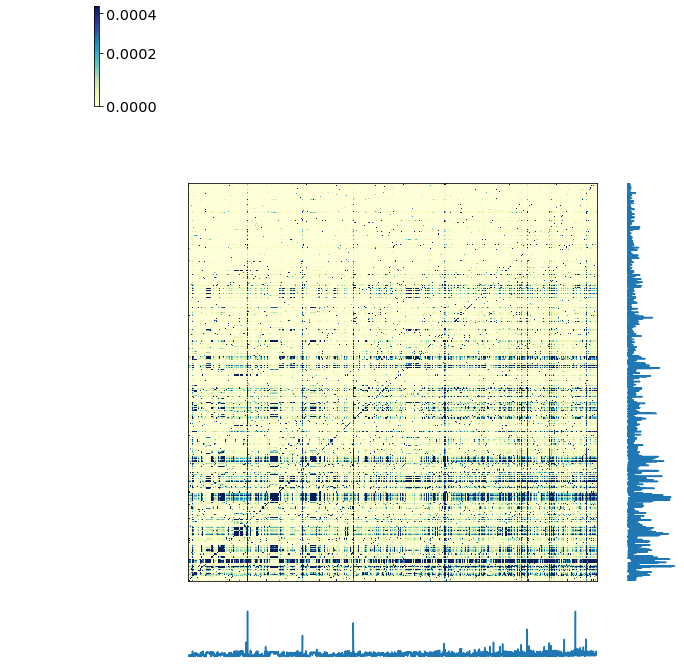

In [13]:

colors_ = ['red' if i in sensors_pcc.orf_name.values else 'blue' if i in effector_pcc.orf_name.values else 'none' for i in e_pcc.nodes]
fig = plt.figure(figsize=(12, 12))
from matplotlib import gridspec, colors as clr
gs = gridspec.GridSpec(4,4, width_ratios=[1,.2,4,.5], height_ratios=[1,.2,4,.5])
ax_row_dend = fig.add_subplot(gs[2,0])
ax_col_dend = fig.add_subplot(gs[0,2])
ax_row_dend.set_axis_off()
ax_col_dend.set_axis_off()

# ax_row_colors = fig.add_subplot(gs[2,1])
# ax_col_colors = fig.add_subplot(gs[1,2])

ax_heatmap = fig.add_subplot(gs[2,2])

ax_row_data = fig.add_subplot(gs[2,3])
ax_row_data.set_axis_off()

ax_col_data = fig.add_subplot(gs[3,2])
ax_col_data.set_axis_off()
# Y = sch.linkage(D, method='centroid')
# orientation='left' is reponsible for making the
# dendrogram appear to the left
# Z1 = sch.dendrogram(row_linkage, orientation='left',
#         link_color_func=lambda k: 'black', 
#                     ax = ax_row_dend)
# # top side dendogram
# #Y = sch.linkage(D, method='single')
# Z2 = sch.dendrogram(col_linkage, color_threshold=0, 
#                    link_color_func=lambda k: 'black',
#                    ax = ax_col_dend)


#axmatrix = fig.add_axes([0.3, 0.1, 0.6, 0.6])
# idx1 = Z1['leaves']
# idx2 = Z2['leaves']

# matrix, cmap = ClusterGrid.color_list_to_matrix_and_cmap(colors_, idx1,axis=0)
# heatmap(np.flip(matrix), cmap=cmap, cbar=False, ax = ax_row_colors, xticklabels=False, yticklabels=False)

# matrix, cmap = ClusterGrid.color_list_to_matrix_and_cmap(colors_, idx2,axis=1)
# heatmap(matrix, cmap=cmap, cbar=False, ax = ax_col_colors, xticklabels=False, yticklabels=False)

#prs_mat = e_pcc.prs_mat
#prs_mat = prs_mat[idx1, :]
#prs_mat = prs_mat[:, idx2]
# prs_mat_cl = prs_mat_cl[idx1, :]
# prs_mat_cl = prs_mat_cl[:, idx2]
# the actual heat-map
im = ax_heatmap.matshow(prs_mat_cl, aspect='auto',
                      origin='lower', cmap="YlGnBu",norm=clr.PowerNorm(gamma=0.8))


# xticks to the right (x-axis)
#ax_heatmap.set_xticks(range(40))
#ax_heatmap.set_xticklabels(idx1, minor=False)
ax_heatmap.xaxis.set_label_position('bottom')
ax_heatmap.xaxis.tick_bottom()

plt.xticks(rotation=-90, fontsize=8)  # ,colors='black')

# xticks to the right (y-axis)
#ax_heatmap.set_yticks(range(40))
#ax_heatmap.set_yticklabels(idx2, minor=False)
ax_heatmap.yaxis.set_label_position('right')
ax_heatmap.yaxis.tick_right()
#ax_heatmap.set_axis_off()

ax_heatmap.set_xticks([])
ax_heatmap.set_yticks([])
# to add the color bar
# axcolor = fig.add_axes([0.94, 0.1, 0.02, 0.6])
ax_colorbar = fig.add_subplot(gs[0, 0])
ax_colorbar.set_axis_off()
#ax_colorbar = fig.add_axes([0.0, 0.71, 0.1, .2])
row_data = np.mean(prs_mat, axis=1)
    # ,orientation=u'vertical')
ax_row_data.plot((row_data), range(len(row_data)), '-')
ax_row_data.set_ylim(0,len(row_data))

col_data = np.mean(prs_mat, axis=0)
    # ,orientation=u'vertical')
ax_col_data.plot(range(len(col_data)), col_data, '-')
ax_col_data.set_xlim(0,len(col_data))
#plt.axis('off')
#ax_col_data.axhline(np.quantile(col_data,0.99),c='orange',linestyle=':')
#ax_row_data.axvline(np.quantile(row_data,0.99),c='orange',linestyle=':')

cbar = plt.colorbar(im, ax=ax_colorbar)
cbar.set_ticks([0,0.0002,0.0004])
plt.show()


# Normalized all

In [471]:
help(sch.distance.pdist)

Help on function pdist in module scipy.spatial.distance:

pdist(X, metric='euclidean', *args, **kwargs)
    Pairwise distances between observations in n-dimensional space.
    
    See Notes for common calling conventions.
    
    Parameters
    ----------
    X : ndarray
        An m by n array of m original observations in an
        n-dimensional space.
    metric : str or function, optional
        The distance metric to use. The distance function can
        be 'braycurtis', 'canberra', 'chebyshev', 'cityblock',
        'correlation', 'cosine', 'dice', 'euclidean', 'hamming',
        'jaccard', 'jensenshannon', 'kulsinski', 'mahalanobis', 'matching',
        'minkowski', 'rogerstanimoto', 'russellrao', 'seuclidean',
        'sokalmichener', 'sokalsneath', 'sqeuclidean', 'yule'.
    *args : tuple. Deprecated.
        Additional arguments should be passed as keyword arguments
    **kwargs : dict, optional
        Extra arguments to `metric`: refer to each metric documentation for a

In [36]:
prs_mat = e_pcc.prs_mat
quantile_threshold =  0.95
method = 'ward'
dist_method = 'seuclidean'
q99 = np.quantile(prs_mat, quantile_threshold)
prs_mat_cl = copy.deepcopy(prs_mat)
prs_mat_cl[prs_mat_cl > q99] = q99
prs_mat_cl_orig = prs_mat_cl
# , optimal_ordering=True)
row_dist = sch.distance.pdist(prs_mat_cl,metric=dist_method)
row_linkage_cl = sch.linkage(row_dist, method=method)
row_linkage_olo = sch.optimal_leaf_ordering(row_linkage_cl,row_dist)
# ,optimal_ordering=True)
col_dist = sch.distance.pdist(prs_mat_cl.T, metric = dist_method)
col_linkage_cl = sch.linkage(col_dist, method=method)
col_linkage_olo = sch.optimal_leaf_ordering(col_linkage_cl,col_dist)


/home/oma21/miniconda3/envs/enm/lib/python3.7/site-packages/ipykernel_launcher.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/oma21/miniconda3/envs/enm/lib/python3.7/site-packages/ipykernel_launcher.py:61: UserWarning: FixedFormatter should only be used together with FixedLocator


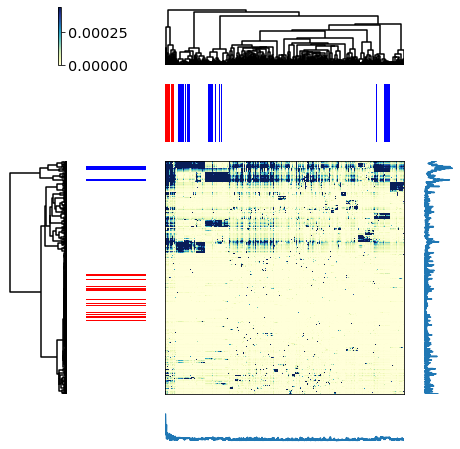

In [37]:

colors = ['red' if i in sensors_pcc.orf_name.values else 'blue' if i in effector_pcc.orf_name.values else 'none' for i in e_pcc.nodes]
fig = plt.figure(figsize=(8, 8))
from matplotlib import gridspec
gs = gridspec.GridSpec(4,4, width_ratios=[1,1,4,.5], height_ratios=[1,1,4,.5])
ax_row_dend = fig.add_subplot(gs[2,0])
ax_col_dend = fig.add_subplot(gs[0,2])
ax_row_dend.set_axis_off()
ax_col_dend.set_axis_off()

ax_row_colors = fig.add_subplot(gs[2,1])
ax_col_colors = fig.add_subplot(gs[1,2])

ax_heatmap = fig.add_subplot(gs[2,2])

ax_row_data = fig.add_subplot(gs[2,3])
ax_row_data.set_axis_off()

ax_col_data = fig.add_subplot(gs[3,2])
ax_col_data.set_axis_off()
# orientation='left' is reponsible for making the
# dendrogram appear to the left
Z1_cl = sch.dendrogram(row_linkage_olo, orientation='left',
        link_color_func=lambda k: 'black', ax = ax_row_dend)
# top side dendogram
#Y = sch.linkage(D, method='single')
Z2_cl = sch.dendrogram(col_linkage_olo, color_threshold=0, 
                    link_color_func=lambda k: 'black',
                   ax = ax_col_dend)


#axmatrix = fig.add_axes([0.3, 0.1, 0.6, 0.6])
idx1_cl = Z1_cl['leaves']
idx2_cl = Z2_cl['leaves']

matrix, cmap = ClusterGrid.color_list_to_matrix_and_cmap(colors, idx1_cl,axis=0)
heatmap(np.flip(matrix), cmap=cmap, cbar=False, ax = ax_row_colors, xticklabels=False, yticklabels=False)

matrix, cmap = ClusterGrid.color_list_to_matrix_and_cmap(colors, idx2_cl,axis=1)
heatmap(matrix, cmap=cmap, cbar=False, ax = ax_col_colors, xticklabels=False, yticklabels=False)

#prs_mat = e_pcc.prs_mat
#prs_mat = prs_mat[idx1, :]
#prs_mat = prs_mat[:, idx2]
prs_mat_cl = prs_mat_cl_orig[idx1_cl, :]
prs_mat_cl = prs_mat_cl[:, idx2_cl]
# the actual heat-map
im = ax_heatmap.matshow(prs_mat_cl, aspect='auto', #norm=mpl.colors.PowerNorm(gamma=2), 
                      origin='lower', cmap="YlGnBu")


# xticks to the right (x-axis)
#ax_heatmap.set_xticks(range(40))
ax_heatmap.set_xticklabels(idx1_cl, minor=False)
ax_heatmap.xaxis.set_label_position('bottom')
ax_heatmap.xaxis.tick_bottom()

plt.xticks(rotation=-90, fontsize=8)  # ,colors='black')

# xticks to the right (y-axis)
#ax_heatmap.set_yticks(range(40))
ax_heatmap.set_yticklabels(idx2_cl, minor=False)
ax_heatmap.yaxis.set_label_position('right')
ax_heatmap.yaxis.tick_right()
#ax_heatmap.set_axis_off()
# to add the color bar
# axcolor = fig.add_axes([0.94, 0.1, 0.02, 0.6])
ax_colorbar = fig.add_subplot(gs[0, 0])
ax_colorbar.set_axis_off()
row_data = np.mean(prs_mat[idx1_cl,:], axis=1)#np.mean(prs_mat_cl, axis=1)
    # ,orientation=u'vertical')
ax_row_data.plot((row_data), range(len(row_data)), '-')
ax_row_data.set_ylim(0,len(row_data))

col_data = np.mean(prs_mat[:,idx2_cl], axis=0)#np.mean(prs_mat_cl, axis=0)
    # ,orientation=u'vertical')
ax_col_data.plot(range(len(col_data)), col_data, '-')
ax_col_data.set_xlim(0,len(col_data))
#plt.axis('off')
#plt.axis('off')
ax_heatmap.set_xticks([])
ax_heatmap.set_yticks([])
plt.colorbar(im, ax=ax_colorbar)
plt.show()


In [395]:
row_dist = sch.distance.pdist(prs_mat_cl)
col_dist = sch.distance.pdist(prs_mat_cl.T)

row_dist_sqr = sch.distance.squareform(row_dist)
col_dist_sqr = sch.distance.squareform(col_dist)


In [39]:
%%R -o sensor_colors -o effector_colors
library(RColorBrewer)
col = brewer.pal(n=9,name='Set1')
sensor_colors = col[1:6]
effector_colors = col[7:9]


In [40]:

effector_order = effector_pcc.groupby('go_group').eff.median().sort_values().index.tolist()
sensor_order = sensors_pcc.groupby('go_group').sens.median().sort_values().index.tolist()

effector_colors_dict = dict(zip(effector_order,effector_colors))
sensor_colors_dict = dict(zip(sensor_order,sensor_colors))
sensor_colors_dict[None]='none'

eff_sens_color_list = [sensor_colors_dict[sensors_pcc.loc[sensors_pcc.orf_name==i,'go_group'].item()] if i in sensors_pcc.orf_name.values else 
                       effector_colors_dict[effector_pcc.loc[effector_pcc.orf_name==i,'go_group'].item()] if i in effector_pcc.orf_name.values else 
'none' for i in e_pcc.nodes]

/home/oma21/miniconda3/envs/enm/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/oma21/miniconda3/envs/enm/lib/python3.7/site-packages/ipykernel_launcher.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator


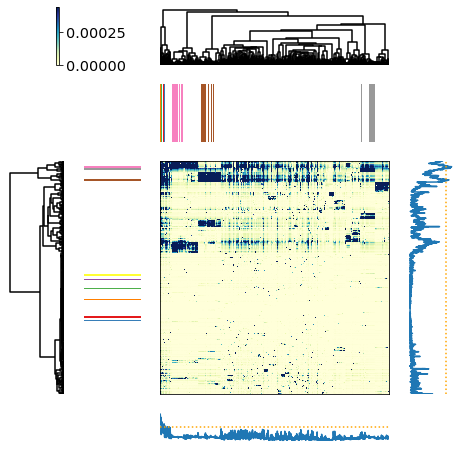

In [42]:

#colors = ['red' if i in sensors_pcc.orf_name.values else 'blue' if i in effector_pcc.orf_name.values else 'none' for i in e_pcc.nodes]
fig = plt.figure(figsize=(8, 8))
from matplotlib import gridspec
gs = gridspec.GridSpec(4,4, width_ratios=[1,1,4,.8], height_ratios=[1,1,4,.5])
ax_row_dend = fig.add_subplot(gs[2,0])
ax_col_dend = fig.add_subplot(gs[0,2])
ax_row_dend.set_axis_off()
ax_col_dend.set_axis_off()

ax_row_colors = fig.add_subplot(gs[2,1])
ax_col_colors = fig.add_subplot(gs[1,2])

ax_heatmap = fig.add_subplot(gs[2,2])

ax_row_data = fig.add_subplot(gs[2,3])
ax_row_data.set_axis_off()

ax_col_data = fig.add_subplot(gs[3,2])
ax_col_data.set_axis_off()
# Y = sch.linkage(D, method='centroid')
# orientation='left' is reponsible for making the
# dendrogram appear to the left
Z1_cl = sch.dendrogram(row_linkage_olo, orientation='left',
        link_color_func=lambda k: 'black', ax = ax_row_dend)
# top side dendogram
#Y = sch.linkage(D, method='single')
Z2_cl = sch.dendrogram(col_linkage_olo, color_threshold=0, 
                    link_color_func=lambda k: 'black',
                   ax = ax_col_dend)


#axmatrix = fig.add_axes([0.3, 0.1, 0.6, 0.6])
idx1_cl = Z1_cl['leaves']
idx2_cl = Z2_cl['leaves']

matrix, cmap = ClusterGrid.color_list_to_matrix_and_cmap(eff_sens_color_list, idx1_cl,axis=0)
heatmap(np.flip(matrix), cmap=cmap, cbar=False, ax = ax_row_colors, xticklabels=False, yticklabels=False)

matrix, cmap = ClusterGrid.color_list_to_matrix_and_cmap(eff_sens_color_list, idx2_cl,axis=1)
heatmap(matrix, cmap=cmap, cbar=False, ax = ax_col_colors, xticklabels=False, yticklabels=False)

#prs_mat = e_pcc.prs_mat
#prs_mat = prs_mat[idx1, :]
#prs_mat = prs_mat[:, idx2]
prs_mat_cl = prs_mat_cl_orig[idx1_cl, :]
prs_mat_cl = prs_mat_cl[:, idx2_cl]
# the actual heat-map
im = ax_heatmap.matshow(prs_mat_cl, aspect='auto', #norm=mpl.colors.PowerNorm(gamma=2), 
                      origin='lower', cmap="YlGnBu")


# xticks to the right (x-axis)
#ax_heatmap.set_xticks(range(40))
ax_heatmap.set_xticklabels(idx1_cl, minor=False)
ax_heatmap.xaxis.set_label_position('bottom')
ax_heatmap.xaxis.tick_bottom()

plt.xticks(rotation=-90, fontsize=8)  # ,colors='black')

# xticks to the right (y-axis)
#ax_heatmap.set_yticks(range(40))
ax_heatmap.set_yticklabels(idx2_cl, minor=False)
ax_heatmap.yaxis.set_label_position('right')
ax_heatmap.yaxis.tick_right()
#ax_heatmap.set_axis_off()
# to add the color bar
# axcolor = fig.add_axes([0.94, 0.1, 0.02, 0.6])
ax_colorbar = fig.add_subplot(gs[0, 0])
ax_colorbar.set_axis_off()
#ax_colorbar = fig.add_axes([0.0, 0.71, 0.1, .2])
row_data = np.mean(prs_mat_cl, axis=1)#np.mean(prs_mat_cl, axis=1)
    # ,orientation=u'vertical')
ax_row_data.plot((row_data), range(len(row_data)), '-')
ax_row_data.set_ylim(0,len(row_data))
ax_row_data.axvline(np.quantile(row_data,0.99),c='orange',linestyle=':')

col_data = np.mean(prs_mat_cl, axis=0)#np.mean(prs_mat_cl, axis=0)
    # ,orientation=u'vertical')
ax_col_data.plot(range(len(col_data)), col_data, '-')
ax_col_data.set_xlim(0,len(col_data))
ax_col_data.axhline(np.quantile(col_data,0.99),c='orange',linestyle=':')
#plt.axis('off')
ax_heatmap.set_xticks([])
ax_heatmap.set_yticks([])
plt.colorbar(im, ax=ax_colorbar)
#plt.show()
#plt.savefig('reports/figures/heatmap_clustering_0201/go_colored.pdf',dpi=75)

In [53]:
root_row, tree_list_row = sch.to_tree(row_linkage_olo, True)
root_col, tree_list_col = sch.to_tree(col_linkage_olo, True)


In [108]:
sch.cut_tree(e_pcc.row_linkage,n_clusters = 10)

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

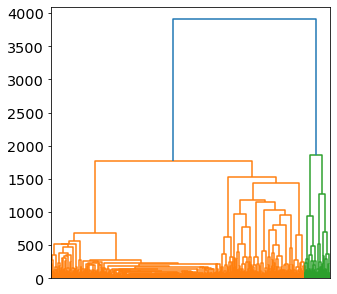

In [136]:
fig, ax = plt.subplots()
zz = sch.dendrogram(e_pcc.row_linkage,ax=ax,no_labels=True)
plt.show()

In [126]:
zz.keys()

dict_keys(['icoord', 'dcoord', 'ivl', 'leaves', 'color_list'])

In [127]:
help(sch.dendrogram)

Help on function dendrogram in module scipy.cluster.hierarchy:

dendrogram(Z, p=30, truncate_mode=None, color_threshold=None, get_leaves=True, orientation='top', labels=None, count_sort=False, distance_sort=False, show_leaf_counts=True, no_plot=False, no_labels=False, leaf_font_size=None, leaf_rotation=None, leaf_label_func=None, show_contracted=False, link_color_func=None, ax=None, above_threshold_color='C0')
    Plot the hierarchical clustering as a dendrogram.
    
    The dendrogram illustrates how each cluster is
    composed by drawing a U-shaped link between a non-singleton
    cluster and its children. The top of the U-link indicates a
    cluster merge. The two legs of the U-link indicate which clusters
    were merged. The length of the two legs of the U-link represents
    the distance between the child clusters. It is also the
    cophenetic distance between original observations in the two
    children clusters.
    
    Parameters
    ----------
    Z : ndarray
        Th

In [135]:
e_pcc.root_col.left.right.right.left.get_count()

24

# Changing effector-sensor calculations

In [43]:
eff = np.sum(prs_mat_cl_orig,axis=1)
sens = np.sum(prs_mat_cl_orig,axis=0)

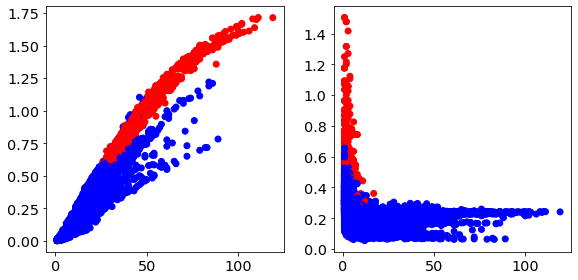

In [54]:
fig , ax = plt.subplots(1,2,figsize=(8,4))
ax[0].scatter(e_pcc.degree, eff,c=['red' if i in root_row.right.pre_order() else 'blue' for i in range(5183) ])
ax[1].scatter(e_pcc.degree, sens, c=['red' if i in root_col.left.pre_order() else 'blue' for i in range(5183) ])
plt.tight_layout()

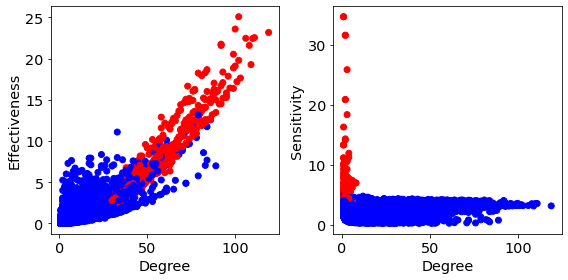

In [72]:
fig , ax = plt.subplots(1,2,figsize=(8,4))
ax[0].scatter(e_pcc.degree, e_pcc.df.eff,c=['red' if i in root_row.right.pre_order() else 'blue' for i in range(5183) ])
ax[0].set_xlabel('Degree')
ax[1].set_xlabel('Degree')
ax[0].set_ylabel('Effectiveness')
ax[1].set_ylabel('Sensitivity')
ax[1].scatter(e_pcc.degree, e_pcc.df.sens, c=['red' if i in root_col.left.pre_order() else 'blue' for i in range(5183) ])
plt.tight_layout()

# Getting effectors and sensors from clusters

Take the right cluster nodes and create a subnetwork/dataframe

In [56]:
right_cluster_df = e_pcc.df.iloc[root_row.right.pre_order(),:]
right_cluster_df['sub_cluster']=np.where(right_cluster_df.index.isin(root.right.right.right.pre_order()),1,
                                        np.where(right_cluster_df.index.isin(root.right.right.left.pre_order()),2,
                                                np.where(right_cluster_df.index.isin(root.right.left.left.pre_order()),3,4)))
right_cluster_induced = nx.induced_subgraph(e_pcc.graph_gc,right_cluster_df.orf_name.tolist())
nx.set_node_attributes(right_cluster_induced,right_cluster_df.sub_cluster,'sub_cluster')
#len([i for i in nx.connected_components(right_cluster_induced)])

/home/oma21/miniconda3/envs/enm/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [75]:
len([i for i in nx.connected_components(right_cluster_induced)])

2

check the degree and effectiveness distribution

<AxesSubplot:xlabel='deg', ylabel='eff'>

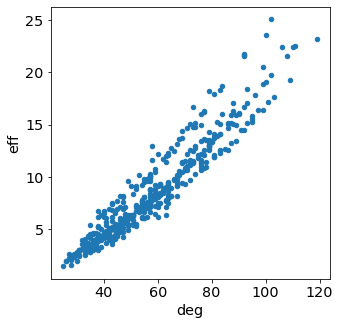

In [57]:
right_cluster_df.reindex().plot.scatter('deg','eff')

4 sub clusters of the top-right subcluster

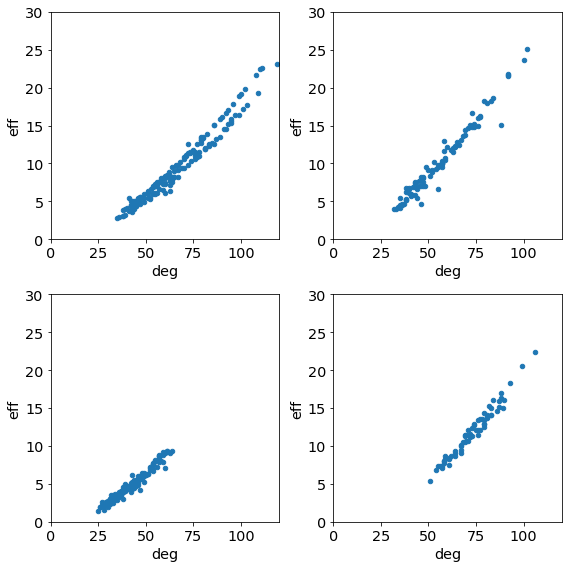

In [59]:
fig ,ax = plt.subplots(2,2,figsize=(8,8))
e_pcc.df.iloc[root_row.right.right.right.pre_order(),:].plot.scatter('deg','eff',ax=ax[0][0])
e_pcc.df.iloc[root_row.right.right.left.pre_order(),:].plot.scatter('deg','eff',ax=ax[0][1])
e_pcc.df.iloc[root_row.right.left.right.pre_order(),:].plot.scatter('deg','eff',ax=ax[1][0])
e_pcc.df.iloc[root_row.right.left.left.pre_order(),:].plot.scatter('deg','eff',ax=ax[1][1])

plt.setp(ax, xlim=(0,120), ylim=(0,30))
plt.tight_layout()

Plot effector clusters from 1% threshold and clusters from row dendrogram above

In [69]:
[i for i in  reversed(range(4))]

[3, 2, 1, 0]

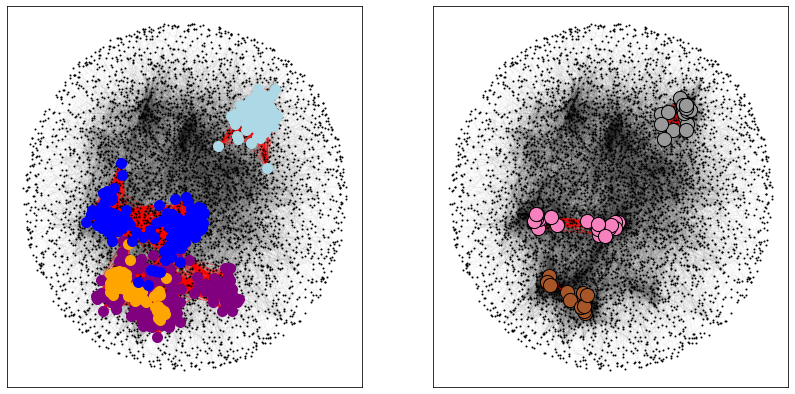

In [70]:
pos = e_pcc.graph_gc.nodes('pos')
clrs = ['blue','lightblue','orange','purple']
fig, ax = plt.subplots(1,2, figsize=(14,7))
legend_elements = [Line2D([0], [0], marker='o', color='black', label='Genes',
                              markerfacecolor='black', markersize=4, linestyle="None"),
                   Line2D([0], [0], marker='o', color='black', label='Effectors',
                              markerfacecolor='black', markersize=10, linestyle="None"),
                   Line2D([0], [0], marker='^', color='black', label='Sensors',
                              markerfacecolor='black', markersize=10, linestyle="None"),
                       Line2D([0], [0], marker='o', color='black', label= 'High functional similarity',
                              markerfacecolor='black', markersize=0, linestyle="-"),
                   Line2D([0], [0], marker='o', color='red', label= 'Sensor-Sensor edges',
                              markerfacecolor='#018571', markersize=0, linestyle="-"),
                   Line2D([0], [0], marker='o', color='blue', label= 'Effector-Effector edges',
                              markerfacecolor='#a6611a', markersize=0, linestyle="-")
                       ]
e_pcc.plot_network_spring(ax=ax[0],
                          node_size=1,
                          node_color='black',
 #                        node_size = [100 if i in sensors_pcc.orf_name.values or i in effector_pcc.orf_name.values else 1 for i in e_pcc.nodes],
                         #node_color = ['red' if i in sensors_pcc.orf_name.values else 'blue' if i in effector_pcc.orf_name.values else 'black' for i in e_pcc.nodes],
                         edge_color='black')
#                         node_shape=['^' if i in sensors_pcc.orf_name.values else 'v' if i in effector_pcc.orf_name.values else 'o' for i in e_pcc.nodes])
for i in  reversed(range(4)):
    nx.draw_networkx_nodes(e_pcc.graph_gc, nodelist=right_cluster_df.loc[right_cluster_df.sub_cluster==i+1].orf_name.values, node_size=100, pos=pos,
                      node_color=clrs[i],
                      node_shape='o', ax = ax[0])
nx.draw_networkx_edges(right_cluster_induced, ax=ax[0] , pos=pos, edge_color='red', alpha=0.5)
ax[0].set_facecolor('white')
#lgd = ax.legend(handles=legend_elements, fontsize=18,loc='center left', bbox_to_anchor=(1.1, 0.5))
###############################################
legend_elements = [    ]

e_pcc.plot_network_spring(ax=ax[1],
                          node_size=1,
                          node_color='black',
 #                        node_size = [100 if i in sensors_pcc.orf_name.values or i in effector_pcc.orf_name.values else 1 for i in e_pcc.nodes],
                         #node_color = ['red' if i in sensors_pcc.orf_name.values else 'blue' if i in effector_pcc.orf_name.values else 'black' for i in e_pcc.nodes],
                         edge_color='black',savefig=False)
#                         node_shape=['^' if i in sensors_pcc.orf_name.values else 'v' if i in effector_pcc.orf_name.values else 'o' for i in e_pcc.nodes])
# nx.draw_networkx_nodes(e_pcc.graph_gc, nodelist=sensors_pcc.orf_name.values, node_size=200, pos=pos,
#                           node_color='black',
#                           node_shape='^',edgecolors='black',
#                           linewidths=1, ax=ax[1])
# for itr, i in enumerate(sensor_order):
#     #print(i, effector_colors[itr])

#     orf_names_to_plot = sensors_pcc.loc[sensors_pcc.go_group==i, 'orf_name'].tolist()
#     nx.draw_networkx_nodes(e_pcc.graph_gc, nodelist=orf_names_to_plot, node_size=200, pos=pos,
#                           node_color=sensor_colors[itr],
#                           node_shape='^',edgecolors='black',
#                           linewidths=1,ax=ax[1])
#     legend_elements.append(
#         Line2D([0], [0], marker='^', color='black', label=f'Sensors ({i})',
#                               markerfacecolor=sensor_colors[itr], markersize=12, linestyle="None")
#     )
nx.draw_networkx_nodes(e_pcc.graph_gc, nodelist=effector_pcc.orf_name.values, node_size=100, pos=pos,
                      node_color='black',
                      node_shape='o', ax=ax[1])
for itr, i in enumerate(effector_order):
    orf_names_to_plot = effector_pcc.loc[effector_pcc.go_group==i,'orf_name'].tolist()
    nx.draw_networkx_nodes(e_pcc.graph_gc, nodelist=orf_names_to_plot, node_size=200, pos=pos,
                          node_color=effector_colors[itr],
                          node_shape='o',edgecolors='black',
                          linewidths=1,ax=ax[1])
    if i == 'mito':
        lbl = 'Respiratory complex assembly'
    elif i == 'golgi':
        lbl = "Golgi vesicle transport"
    else:
        lbl = 'Chromosome segragation'
    legend_elements.append(
            Line2D([0], [0], marker='o', color='black', label=f'Effectors ({lbl})',
                                  markerfacecolor=effector_colors[itr], markersize=12, linestyle="None")
        )
#nx.draw_networkx_edges(nx.induced_subgraph(e_pcc.graph_gc, sensors_pcc.orf_name.tolist()), ax=ax[1] , pos=pos, edge_color='red', alpha=0.5)
ax[1].set_facecolor('white')
legend_elements.extend(
    [Line2D([0], [0], marker='o', color='black', label='Genes',
                              markerfacecolor='black', markersize=4, linestyle="None"),
#                    Line2D([0], [0], marker='o', color='black', label='Effectors',
#                               markerfacecolor='black', markersize=10, linestyle="None"),
#                    Line2D([0], [0], marker='^', color='black', label='Sensors',
#                               markerfacecolor='black', markersize=10, linestyle="None"),
                       Line2D([0], [0], marker='o', color='black', label= 'High functional similarity',
                              markerfacecolor='black', markersize=0, linestyle="-"),
                   Line2D([0], [0], marker='o', color='red', label= 'Sensor-Sensor edges',
                              markerfacecolor='#018571', markersize=0, linestyle="-"),
                   Line2D([0], [0], marker='o', color='blue', label= 'Effector-Effector edges',
                              markerfacecolor='#a6611a', markersize=0, linestyle="-")]
)
#lgd = ax[1].legend(handles=legend_elements, fontsize=22,loc='center left', bbox_to_anchor=(1.1, 0.5))

nx.draw_networkx_edges(nx.induced_subgraph(e_pcc.graph_gc, effector_pcc.orf_name.tolist()), ax=ax[1] , pos=pos, edge_color='red',alpha=0.5)
#plt.savefig('tmp_nw.png',bbox_inches='tight')

# Go analysis of different clusters

In [22]:
goea, geneid2name = create_goea(gaf = 'data/raw/ontology/sgd.gaf', obo_fname='data/raw/ontology/go-basic.obo', background='data/interim/costanzo_gc_bg.tsv', sgd_info_tab = 'data/raw/ontology/SGD_features.tab')

data/raw/ontology/go-basic.obo: fmt(1.2) rel(2019-06-01) 47,444 GO Terms
HMS:0:00:02.422944 119,640 annotations READ: data/raw/ontology/sgd.gaf 

Load BP Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 84%  3,934 of  4,660 population items found in association

Load CC Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 89%  4,168 of  4,660 population items found in association

Load MF Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 73%  3,399 of  4,660 population items found in association


In [344]:
right_subclusters_go = []
for i in range(4):

    right_subclusters_go.append(goa_df)



Run BP Gene Ontology Analysis: current study set of 195 IDs ... 95%    186 of    195 study items found in association
100%    195 of    195 study items found in population(4660)
Calculating 2,792 uncorrected p-values using fisher_scipy_stats
   2,792 GO terms are associated with  3,934 of  4,660 population items
     380 GO terms are associated with    186 of    195 study items
  METHOD fdr_bh:
      29 GO terms found significant (< 0.05=alpha) ( 28 enriched +   1 purified): statsmodels fdr_bh
     148 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 195 IDs ... 96%    187 of    195 study items found in association
100%    195 of    195 study items found in population(4660)
Calculating 795 uncorrected p-values using fisher_scipy_stats
     795 GO terms are associated with  4,168 of  4,660 population items
     206 GO terms are associated with    187 of    19

In [373]:
qgrid.show_grid(right_subclusters_go[2].loc[right_subclusters_go[2].NS=='BP'])

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [374]:
qgrid.show_grid(right_subclusters_go[3].loc[right_subclusters_go[3].NS=='BP'])

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [233]:
eff_chr_cluster = e_pcc.df.iloc[root.right.left.left.right.pre_order()]
eff_mito_cluster = e_pcc.df.iloc[root.right.right.left.left.pre_order()]
eff_golgi_cluster = e_pcc.df.iloc[root.right.right.left.right.pre_order()]

In [268]:
goa_df = query_goatools(e_pcc.df.iloc[root.right.pre_order()],
               goea,geneid2name)


Run BP Gene Ontology Analysis: current study set of 629 IDs ... 96%    603 of    629 study items found in association
100%    629 of    629 study items found in population(4660)
Calculating 2,792 uncorrected p-values using fisher_scipy_stats
   2,792 GO terms are associated with  3,934 of  4,660 population items
     972 GO terms are associated with    603 of    629 study items
  METHOD fdr_bh:
     108 GO terms found significant (< 0.05=alpha) ( 98 enriched +  10 purified): statsmodels fdr_bh
     477 study items associated with significant GO IDs (enriched)
      26 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 629 IDs ... 96%    606 of    629 study items found in association
100%    629 of    629 study items found in population(4660)
Calculating 795 uncorrected p-values using fisher_scipy_stats
     795 GO terms are associated with  4,168 of  4,660 population items
     399 GO terms are associated with    606 of    62

In [230]:
sum(e_pcc.df.iloc[root.right.left.left.right.pre_order()].orf_name.isin(effector_pcc.orf_name))

12

In [217]:
[i for i in goa_df.loc[goa_df.NS=='BP'].iloc[4].study_items if i in effector_pcc.loc[:,'Systematic gene name'].tolist()]

['YJL004C',
 'YBR164C',
 'YNL041C',
 'YDL145C',
 'YPL051W',
 'YML071C',
 'YNL051W',
 'YMR197C',
 'YFL038C']

In [269]:
qgrid.show_grid(goa_df.loc[goa_df.NS=='BP'])#, row_edit_callback=can_edit_row)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [80]:
help(heatmap_annotated)

Help on function heatmap_annotated in module src.visualize.visualize:

heatmap_annotated(prs_mat, prs_mat_cl_orig, figure_path, row_linkage, col_linkage, row_colors=None, col_colors=None, **kwargs)



/home/oma21/enm_package/src/visualize/visualize.py:334: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_heatmap.set_xticklabels(idx1_cl, minor=False)
/home/oma21/enm_package/src/visualize/visualize.py:342: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_heatmap.set_yticklabels(idx2_cl, minor=False)


(array([0.00225456, 0.00212964, 0.00064455, ..., 0.0018722 , 0.00188671,
        0.00196717]),
 array([0.00670243, 0.00670243, 0.00610539, ..., 0.00030683, 0.00022774,
        0.00013241]))

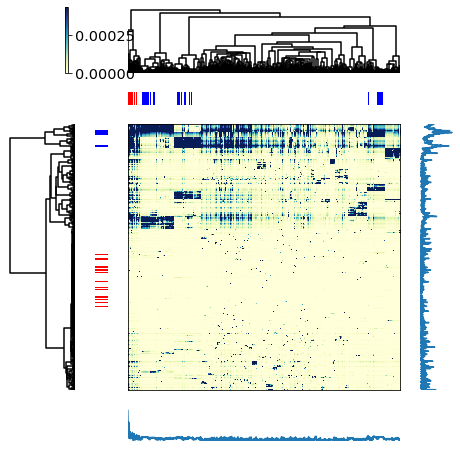

In [82]:
from src.visualize.visualize import heatmap_annotated

heatmap_annotated(prs_mat, prs_mat_cl_orig, figure_path='./', row_linkage=row_linkage_olo, col_linkage=col_linkage_olo,
                 row_colors=colors, col_colors=colors)

In [14]:
e_pcc.prs_mat_cl=None
e_pcc.get_sensor_effector(use_threshold=False)

In [15]:
e_pcc.effectors_df

,orf_name,deg,eig_0,eig_1,eig_2,eig_3,eig_4,eig_5,eig_6,eig_7,...,smallest_eigenvec,Systematic gene name,Allele Gene name,num,cat,bin,group,cat_,neighbor_btw,neighbor_degree
1661,tub3,51,0.007501,-0.000807,-0.000476,0.002077,0.000209,0.001395,-0.015312,0.001126,...,-0.000572,YML124C,tub3,8130,na.nq,82,nonessential,Nonessential\nquery and array,0.001105,51.470588
1206,hcm1,61,0.007531,-0.000582,-0.000192,0.003171,-0.002185,0.005049,-0.017705,0.001827,...,-0.000577,YCR065W,hcm1,7600,na.nq.nxes,76,nonessential,Nonessential\nquery and array,0.000877,50.737705
2309,cin2,61,0.005991,-0.000975,-0.000298,0.001034,-0.000282,0.001012,-0.012696,0.002950,...,-0.000573,YPL241C,cin2,8726,na.nq.nxes,88,nonessential,Nonessential\nquery and array,0.001109,51.786885
2308,cin1,67,0.005894,-0.001097,-0.000042,0.000769,-0.000541,0.001526,-0.012729,0.001593,...,-0.000574,YOR349W,cin1,8677,na.nq.nxes,87,nonessential,Nonessential\nquery and array,0.001062,51.955224
269,stu2-11,67,0.005042,-0.000671,0.000126,0.000662,-0.000157,0.001275,-0.010460,0.002141,...,-0.000576,YLR045C,stu2-11,7478,essential,75,essential,Essential,0.001067,55.820896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1111,keg1-5002-supp1,62,0.000492,-0.007665,0.001233,-0.000004,0.000776,0.000134,0.000079,0.004247,...,-0.000528,YFR042W,keg1-5002-supp1,4309,essential,44,essential,Essential,0.001332,59.758065
1127,mnn2,64,0.000230,-0.009021,0.000416,-0.000256,0.000424,-0.000488,0.000227,0.003138,...,-0.000526,YBR015C,mnn2,8703,na.nq.nxes,88,nonessential,Nonessential\nquery and array,0.001626,59.078125
1104,cne1,66,0.000436,-0.008861,0.001469,-0.000353,0.000557,-0.000595,0.000598,0.004227,...,-0.000526,YAL058W,cne1,8941,na.nq.nxes,90,nonessential,Nonessential\nquery and array,0.001288,63.727273
1073,gwt1-20,66,0.000439,-0.009090,0.001770,-0.000300,0.000817,-0.000552,0.000811,0.004467,...,-0.000527,YJL091C,gwt1-20,7541,essential,76,essential,Essential,0.001195,62.333333


In [16]:
e_pcc.sensors_df

,orf_name,deg,eig_0,eig_1,eig_2,eig_3,eig_4,eig_5,eig_6,eig_7,...,smallest_eigenvec,Systematic gene name,Allele Gene name,num,cat,bin,group,cat_,neighbor_btw,neighbor_degree
755,agp1,1,-0.001621,-0.017052,0.000049,-0.009071,-0.005859,0.000266,-0.004391,-0.000030,...,0.458295,YCL025C,agp1,8132,na.nq,82,nonessential,Nonessential\nquery and array,0.000386,2.0
4914,rma1,1,-0.001621,-0.017052,0.000049,-0.009071,-0.005859,0.000266,-0.004391,-0.000030,...,0.458295,YKL132C,rma1,8082,na.nq,81,nonessential,Nonessential\nquery and array,0.000386,2.0
4913,stp2,2,0.002108,0.001594,-0.000104,0.012430,0.007908,-0.000826,0.005730,0.000128,...,0.428938,YHR006W,stp2,8022,na.nq,81,nonessential,Nonessential\nquery and array,0.000772,2.0
754,dal81,2,0.002108,0.001594,-0.000104,0.012430,0.007908,-0.000826,0.005730,0.000128,...,0.428938,YIR023W,dal81,8760,na.nq.nxes,88,nonessential,Nonessential\nquery and array,0.000772,2.0
2096,stp1,3,0.000988,0.018496,0.000067,0.004468,0.003094,0.001466,0.002644,-0.000380,...,0.372104,YDR463W,stp1,4343,na.only,44,nonessential,Nonessential array,0.000900,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4523,seg1,2,0.007331,-0.000832,-0.002345,0.005680,0.006598,-0.001638,0.004964,0.000443,...,-0.000588,YMR086W,seg1,7971,na.nq,80,nonessential,Nonessential\nquery and array,0.002334,15.0
4513,mch5,2,0.007331,-0.000832,-0.002345,0.005680,0.006598,-0.001638,0.004964,0.000443,...,-0.000588,YOR306C,mch5,7910,na.nq,80,nonessential,Nonessential\nquery and array,0.002334,15.0
5098,ygl177w,2,-0.018655,-0.000784,0.005620,0.009616,-0.001919,-0.000361,0.010996,0.037090,...,-0.000587,YGL177W,ygl177w,4366,na.only,44,nonessential,Nonessential array,0.000430,4.5
4524,tos3,4,-0.004720,0.000308,0.002866,0.000315,-0.001803,0.001530,0.001910,-0.073644,...,-0.000626,YGL179C,tos3,7767,na.nq,78,nonessential,Nonessential\nquery and array,0.000779,4.5


<AxesSubplot:xlabel='eff', ylabel='Density'>

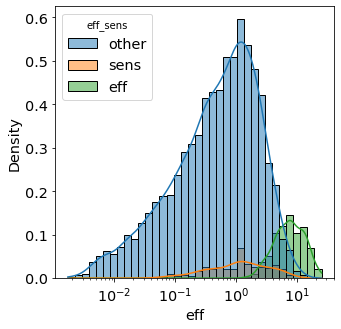

In [17]:
e_pcc.df.loc[:,'eff_sens']=['sens' if i in e_pcc.sensors_df.orf_name.tolist() 
                            else 'eff' if i in e_pcc.effectors_df.orf_name.tolist()
                           else 'other' for i in e_pcc.df.orf_name]
sns.histplot(x='eff',hue='eff_sens',data=e_pcc.df,stat='density',kde=True,log_scale=True)

In [89]:
e_pcc.analyze_components_biology(goea,geneid2name)

/home/oma21/miniconda3/envs/enm/lib/python3.7/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)



Run BP Gene Ontology Analysis: current study set of 17 IDs ... 82%     14 of     17 study items found in association
100%     17 of     17 study items found in population(4660)
Calculating 2,792 uncorrected p-values using fisher_scipy_stats
   2,792 GO terms are associated with  3,934 of  4,660 population items
      41 GO terms are associated with     14 of     17 study items
  METHOD fdr_bh:
       8 GO terms found significant (< 0.05=alpha) (  8 enriched +   0 purified): statsmodels fdr_bh
       8 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 17 IDs ... 82%     14 of     17 study items found in association
100%     17 of     17 study items found in population(4660)
Calculating 795 uncorrected p-values using fisher_scipy_stats
     795 GO terms are associated with  4,168 of  4,660 population items
      11 GO terms are associated with     14 of     17 

     795 GO terms are associated with  4,168 of  4,660 population items
      11 GO terms are associated with     14 of     17 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 17 IDs ... 82%     14 of     17 study items found in association
100%     17 of     17 study items found in population(4660)
Calculating 1,727 uncorrected p-values using fisher_scipy_stats
   1,727 GO terms are associated with  3,399 of  4,660 population items
      45 GO terms are associated with     14 of     17 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with signif

   1,727 GO terms are associated with  3,399 of  4,660 population items
      13 GO terms are associated with      3 of      4 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 5 IDs ... 80%      4 of      5 study items found in association
100%      5 of      5 study items found in population(4660)
Calculating 2,792 uncorrected p-values using fisher_scipy_stats
   2,792 GO terms are associated with  3,934 of  4,660 population items
      16 GO terms are associated with      4 of      5 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with signifi

   2,792 GO terms are associated with  3,934 of  4,660 population items
      15 GO terms are associated with      3 of      4 study items
  METHOD fdr_bh:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): statsmodels fdr_bh
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 4 IDs ... 75%      3 of      4 study items found in association
100%      4 of      4 study items found in population(4660)
Calculating 795 uncorrected p-values using fisher_scipy_stats
     795 GO terms are associated with  4,168 of  4,660 population items
       9 GO terms are associated with      3 of      4 study items
  METHOD fdr_bh:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): statsmodels fdr_bh
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significa

     795 GO terms are associated with  4,168 of  4,660 population items
       8 GO terms are associated with      6 of      7 study items
  METHOD fdr_bh:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): statsmodels fdr_bh
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 7 IDs ... 71%      5 of      7 study items found in association
100%      7 of      7 study items found in population(4660)
Calculating 1,727 uncorrected p-values using fisher_scipy_stats
   1,727 GO terms are associated with  3,399 of  4,660 population items
      14 GO terms are associated with      5 of      7 study items
  METHOD fdr_bh:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): statsmodels fdr_bh
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with signifi

   1,727 GO terms are associated with  3,399 of  4,660 population items
      14 GO terms are associated with      5 of      7 study items
  METHOD fdr_bh:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): statsmodels fdr_bh
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 7 IDs ... 86%      6 of      7 study items found in association
100%      7 of      7 study items found in population(4660)
Calculating 2,792 uncorrected p-values using fisher_scipy_stats
   2,792 GO terms are associated with  3,934 of  4,660 population items
      18 GO terms are associated with      6 of      7 study items
  METHOD fdr_bh:
       4 GO terms found significant (< 0.05=alpha) (  4 enriched +   0 purified): statsmodels fdr_bh
       6 study items associated with significant GO IDs (enriched)
       0 study items associated with signifi

   2,792 GO terms are associated with  3,934 of  4,660 population items
       9 GO terms are associated with      2 of      2 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 2 IDs ...100%      2 of      2 study items found in association
100%      2 of      2 study items found in population(4660)
Calculating 795 uncorrected p-values using fisher_scipy_stats
     795 GO terms are associated with  4,168 of  4,660 population items
      13 GO terms are associated with      2 of      2 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significa

     795 GO terms are associated with  4,168 of  4,660 population items
      13 GO terms are associated with      2 of      2 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 2 IDs ...100%      2 of      2 study items found in association
100%      2 of      2 study items found in population(4660)
Calculating 1,727 uncorrected p-values using fisher_scipy_stats
   1,727 GO terms are associated with  3,399 of  4,660 population items
       4 GO terms are associated with      2 of      2 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with signifi

   1,727 GO terms are associated with  3,399 of  4,660 population items
       4 GO terms are associated with      2 of      2 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 2 IDs ...100%      2 of      2 study items found in association
100%      2 of      2 study items found in population(4660)
Calculating 2,792 uncorrected p-values using fisher_scipy_stats
   2,792 GO terms are associated with  3,934 of  4,660 population items
       9 GO terms are associated with      2 of      2 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with signifi

   2,792 GO terms are associated with  3,934 of  4,660 population items
       9 GO terms are associated with      3 of      4 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 4 IDs ... 75%      3 of      4 study items found in association
100%      4 of      4 study items found in population(4660)
Calculating 795 uncorrected p-values using fisher_scipy_stats
     795 GO terms are associated with  4,168 of  4,660 population items
       8 GO terms are associated with      3 of      4 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significa

     795 GO terms are associated with  4,168 of  4,660 population items
       5 GO terms are associated with      2 of      4 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 4 IDs ...  0%      0 of      4 study items found in association
100%      4 of      4 study items found in population(4660)
Calculating 1,727 uncorrected p-values using fisher_scipy_stats
   1,727 GO terms are associated with  3,399 of  4,660 population items
       0 GO terms are associated with      0 of      4 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with signifi

   1,727 GO terms are associated with  3,399 of  4,660 population items
       4 GO terms are associated with      2 of      4 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 4 IDs ... 50%      2 of      4 study items found in association
100%      4 of      4 study items found in population(4660)
Calculating 2,792 uncorrected p-values using fisher_scipy_stats
   2,792 GO terms are associated with  3,934 of  4,660 population items
       8 GO terms are associated with      2 of      4 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with signifi

   2,792 GO terms are associated with  3,934 of  4,660 population items
       7 GO terms are associated with      4 of      5 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 5 IDs ... 80%      4 of      5 study items found in association
100%      5 of      5 study items found in population(4660)
Calculating 795 uncorrected p-values using fisher_scipy_stats
     795 GO terms are associated with  4,168 of  4,660 population items
      11 GO terms are associated with      4 of      5 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significa

     795 GO terms are associated with  4,168 of  4,660 population items
      15 GO terms are associated with      4 of      4 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 4 IDs ...100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(4660)
Calculating 1,727 uncorrected p-values using fisher_scipy_stats
   1,727 GO terms are associated with  3,399 of  4,660 population items
       4 GO terms are associated with      4 of      4 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with signifi

   1,727 GO terms are associated with  3,399 of  4,660 population items
      17 GO terms are associated with      3 of      5 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 5 IDs ... 80%      4 of      5 study items found in association
100%      5 of      5 study items found in population(4660)
Calculating 2,792 uncorrected p-values using fisher_scipy_stats
   2,792 GO terms are associated with  3,934 of  4,660 population items
      15 GO terms are associated with      4 of      5 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with signifi

   2,792 GO terms are associated with  3,934 of  4,660 population items
      27 GO terms are associated with      5 of      5 study items
  METHOD fdr_bh:
       4 GO terms found significant (< 0.05=alpha) (  4 enriched +   0 purified): statsmodels fdr_bh
       4 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 5 IDs ...100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(4660)
Calculating 795 uncorrected p-values using fisher_scipy_stats
     795 GO terms are associated with  4,168 of  4,660 population items
      11 GO terms are associated with      5 of      5 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significa

     795 GO terms are associated with  4,168 of  4,660 population items
      14 GO terms are associated with      8 of      8 study items
  METHOD fdr_bh:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): statsmodels fdr_bh
       7 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 8 IDs ... 88%      7 of      8 study items found in association
100%      8 of      8 study items found in population(4660)
Calculating 1,727 uncorrected p-values using fisher_scipy_stats
   1,727 GO terms are associated with  3,399 of  4,660 population items
      28 GO terms are associated with      7 of      8 study items
  METHOD fdr_bh:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): statsmodels fdr_bh
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with signifi

   1,727 GO terms are associated with  3,399 of  4,660 population items
      28 GO terms are associated with      7 of      8 study items
  METHOD fdr_bh:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): statsmodels fdr_bh
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 8 IDs ...100%      8 of      8 study items found in association
100%      8 of      8 study items found in population(4660)
Calculating 2,792 uncorrected p-values using fisher_scipy_stats
   2,792 GO terms are associated with  3,934 of  4,660 population items
      31 GO terms are associated with      8 of      8 study items
  METHOD fdr_bh:
       5 GO terms found significant (< 0.05=alpha) (  5 enriched +   0 purified): statsmodels fdr_bh
       7 study items associated with significant GO IDs (enriched)
       0 study items associated with signifi

   2,792 GO terms are associated with  3,934 of  4,660 population items
      73 GO terms are associated with     20 of     24 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 24 IDs ... 92%     22 of     24 study items found in association
100%     24 of     24 study items found in population(4660)
Calculating 795 uncorrected p-values using fisher_scipy_stats
     795 GO terms are associated with  4,168 of  4,660 population items
      33 GO terms are associated with     22 of     24 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with signific

     795 GO terms are associated with  4,168 of  4,660 population items
      33 GO terms are associated with     22 of     24 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 24 IDs ... 75%     18 of     24 study items found in association
100%     24 of     24 study items found in population(4660)
Calculating 1,727 uncorrected p-values using fisher_scipy_stats
   1,727 GO terms are associated with  3,399 of  4,660 population items
      50 GO terms are associated with     18 of     24 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with signif

   1,727 GO terms are associated with  3,399 of  4,660 population items
      50 GO terms are associated with     18 of     24 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 24 IDs ... 83%     20 of     24 study items found in association
100%     24 of     24 study items found in population(4660)
Calculating 2,792 uncorrected p-values using fisher_scipy_stats
   2,792 GO terms are associated with  3,934 of  4,660 population items
      73 GO terms are associated with     20 of     24 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with signif

   2,792 GO terms are associated with  3,934 of  4,660 population items
      73 GO terms are associated with     20 of     24 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 24 IDs ... 92%     22 of     24 study items found in association
100%     24 of     24 study items found in population(4660)
Calculating 795 uncorrected p-values using fisher_scipy_stats
     795 GO terms are associated with  4,168 of  4,660 population items
      33 GO terms are associated with     22 of     24 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with signific

     795 GO terms are associated with  4,168 of  4,660 population items
      33 GO terms are associated with     22 of     24 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 24 IDs ... 75%     18 of     24 study items found in association
100%     24 of     24 study items found in population(4660)
Calculating 1,727 uncorrected p-values using fisher_scipy_stats
   1,727 GO terms are associated with  3,399 of  4,660 population items
      50 GO terms are associated with     18 of     24 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with signif

   1,727 GO terms are associated with  3,399 of  4,660 population items
      50 GO terms are associated with     18 of     24 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 11 IDs ... 91%     10 of     11 study items found in association
100%     11 of     11 study items found in population(4660)
Calculating 2,792 uncorrected p-values using fisher_scipy_stats
   2,792 GO terms are associated with  3,934 of  4,660 population items
      32 GO terms are associated with     10 of     11 study items
  METHOD fdr_bh:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): statsmodels fdr_bh
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with signif

   2,792 GO terms are associated with  3,934 of  4,660 population items
      32 GO terms are associated with     10 of     11 study items
  METHOD fdr_bh:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): statsmodels fdr_bh
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 11 IDs ... 82%      9 of     11 study items found in association
100%     11 of     11 study items found in population(4660)
Calculating 795 uncorrected p-values using fisher_scipy_stats
     795 GO terms are associated with  4,168 of  4,660 population items
      14 GO terms are associated with      9 of     11 study items
  METHOD fdr_bh:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): statsmodels fdr_bh
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with signific

     795 GO terms are associated with  4,168 of  4,660 population items
      14 GO terms are associated with      9 of     11 study items
  METHOD fdr_bh:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): statsmodels fdr_bh
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 11 IDs ... 82%      9 of     11 study items found in association
100%     11 of     11 study items found in population(4660)
Calculating 1,727 uncorrected p-values using fisher_scipy_stats
   1,727 GO terms are associated with  3,399 of  4,660 population items
      23 GO terms are associated with      9 of     11 study items
  METHOD fdr_bh:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): statsmodels fdr_bh
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with signif

   1,727 GO terms are associated with  3,399 of  4,660 population items
      25 GO terms are associated with      9 of     10 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 10 IDs ...100%     10 of     10 study items found in association
100%     10 of     10 study items found in population(4660)
Calculating 2,792 uncorrected p-values using fisher_scipy_stats
   2,792 GO terms are associated with  3,934 of  4,660 population items
      30 GO terms are associated with     10 of     10 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with signif

   2,792 GO terms are associated with  3,934 of  4,660 population items
      30 GO terms are associated with     10 of     10 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 10 IDs ... 80%      8 of     10 study items found in association
100%     10 of     10 study items found in population(4660)
Calculating 795 uncorrected p-values using fisher_scipy_stats
     795 GO terms are associated with  4,168 of  4,660 population items
       8 GO terms are associated with      8 of     10 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with signific

     795 GO terms are associated with  4,168 of  4,660 population items
      11 GO terms are associated with      6 of      6 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 6 IDs ... 83%      5 of      6 study items found in association
100%      6 of      6 study items found in population(4660)
Calculating 1,727 uncorrected p-values using fisher_scipy_stats
   1,727 GO terms are associated with  3,399 of  4,660 population items
      19 GO terms are associated with      5 of      6 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with signifi

   1,727 GO terms are associated with  3,399 of  4,660 population items
      19 GO terms are associated with      5 of      6 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 6 IDs ...100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(4660)
Calculating 2,792 uncorrected p-values using fisher_scipy_stats
   2,792 GO terms are associated with  3,934 of  4,660 population items
      19 GO terms are associated with      6 of      6 study items
  METHOD fdr_bh:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): statsmodels fdr_bh
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with signifi

   2,792 GO terms are associated with  3,934 of  4,660 population items
       6 GO terms are associated with      2 of      4 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 4 IDs ... 75%      3 of      4 study items found in association
100%      4 of      4 study items found in population(4660)
Calculating 795 uncorrected p-values using fisher_scipy_stats
     795 GO terms are associated with  4,168 of  4,660 population items
       6 GO terms are associated with      3 of      4 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significa

     795 GO terms are associated with  4,168 of  4,660 population items
      14 GO terms are associated with      4 of      4 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 4 IDs ...100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(4660)
Calculating 1,727 uncorrected p-values using fisher_scipy_stats
   1,727 GO terms are associated with  3,399 of  4,660 population items
      18 GO terms are associated with      4 of      4 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with signifi

   1,727 GO terms are associated with  3,399 of  4,660 population items
      18 GO terms are associated with      4 of      4 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 6 IDs ...100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(4660)
Calculating 2,792 uncorrected p-values using fisher_scipy_stats
   2,792 GO terms are associated with  3,934 of  4,660 population items
      19 GO terms are associated with      6 of      6 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with signifi

   2,792 GO terms are associated with  3,934 of  4,660 population items
      19 GO terms are associated with      6 of      6 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 6 IDs ...100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(4660)
Calculating 795 uncorrected p-values using fisher_scipy_stats
     795 GO terms are associated with  4,168 of  4,660 population items
      16 GO terms are associated with      6 of      6 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significa

     795 GO terms are associated with  4,168 of  4,660 population items
      10 GO terms are associated with      9 of      9 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 9 IDs ... 89%      8 of      9 study items found in association
100%      9 of      9 study items found in population(4660)
Calculating 1,727 uncorrected p-values using fisher_scipy_stats
   1,727 GO terms are associated with  3,399 of  4,660 population items
      32 GO terms are associated with      8 of      9 study items
  METHOD fdr_bh:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): statsmodels fdr_bh
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with signifi

   1,727 GO terms are associated with  3,399 of  4,660 population items
      32 GO terms are associated with      8 of      9 study items
  METHOD fdr_bh:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): statsmodels fdr_bh
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 9 IDs ...100%      9 of      9 study items found in association
100%      9 of      9 study items found in population(4660)
Calculating 2,792 uncorrected p-values using fisher_scipy_stats
   2,792 GO terms are associated with  3,934 of  4,660 population items
      31 GO terms are associated with      9 of      9 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with signifi

   2,792 GO terms are associated with  3,934 of  4,660 population items
      41 GO terms are associated with     11 of     11 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 11 IDs ...100%     11 of     11 study items found in association
100%     11 of     11 study items found in population(4660)
Calculating 795 uncorrected p-values using fisher_scipy_stats
     795 GO terms are associated with  4,168 of  4,660 population items
      26 GO terms are associated with     11 of     11 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with signific

     795 GO terms are associated with  4,168 of  4,660 population items
      26 GO terms are associated with     11 of     11 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 11 IDs ...100%     11 of     11 study items found in association
100%     11 of     11 study items found in population(4660)
Calculating 1,727 uncorrected p-values using fisher_scipy_stats
   1,727 GO terms are associated with  3,399 of  4,660 population items
      31 GO terms are associated with     11 of     11 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with signif

   1,727 GO terms are associated with  3,399 of  4,660 population items
      31 GO terms are associated with     11 of     11 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 11 IDs ...100%     11 of     11 study items found in association
100%     11 of     11 study items found in population(4660)
Calculating 2,792 uncorrected p-values using fisher_scipy_stats
   2,792 GO terms are associated with  3,934 of  4,660 population items
      41 GO terms are associated with     11 of     11 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with signif

   2,792 GO terms are associated with  3,934 of  4,660 population items
      41 GO terms are associated with     14 of     17 study items
  METHOD fdr_bh:
       8 GO terms found significant (< 0.05=alpha) (  8 enriched +   0 purified): statsmodels fdr_bh
       8 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 17 IDs ... 82%     14 of     17 study items found in association
100%     17 of     17 study items found in population(4660)
Calculating 795 uncorrected p-values using fisher_scipy_stats
     795 GO terms are associated with  4,168 of  4,660 population items
      11 GO terms are associated with     14 of     17 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with signific

     795 GO terms are associated with  4,168 of  4,660 population items
      11 GO terms are associated with     14 of     17 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 17 IDs ... 82%     14 of     17 study items found in association
100%     17 of     17 study items found in population(4660)
Calculating 1,727 uncorrected p-values using fisher_scipy_stats
   1,727 GO terms are associated with  3,399 of  4,660 population items
      45 GO terms are associated with     14 of     17 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with signif

   1,727 GO terms are associated with  3,399 of  4,660 population items
      24 GO terms are associated with     11 of     18 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 18 IDs ... 89%     16 of     18 study items found in association
100%     18 of     18 study items found in population(4660)
Calculating 2,792 uncorrected p-values using fisher_scipy_stats
   2,792 GO terms are associated with  3,934 of  4,660 population items
      39 GO terms are associated with     16 of     18 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with signif

   2,792 GO terms are associated with  3,934 of  4,660 population items
      39 GO terms are associated with     16 of     18 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 18 IDs ... 89%     16 of     18 study items found in association
100%     18 of     18 study items found in population(4660)
Calculating 795 uncorrected p-values using fisher_scipy_stats
     795 GO terms are associated with  4,168 of  4,660 population items
      20 GO terms are associated with     16 of     18 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with signific

     795 GO terms are associated with  4,168 of  4,660 population items
      20 GO terms are associated with     16 of     18 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 18 IDs ... 61%     11 of     18 study items found in association
100%     18 of     18 study items found in population(4660)
Calculating 1,727 uncorrected p-values using fisher_scipy_stats
   1,727 GO terms are associated with  3,399 of  4,660 population items
      24 GO terms are associated with     11 of     18 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with signif

   1,727 GO terms are associated with  3,399 of  4,660 population items
      24 GO terms are associated with     11 of     18 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 18 IDs ... 89%     16 of     18 study items found in association
100%     18 of     18 study items found in population(4660)
Calculating 2,792 uncorrected p-values using fisher_scipy_stats
   2,792 GO terms are associated with  3,934 of  4,660 population items
      39 GO terms are associated with     16 of     18 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with signif

/home/oma21/enm_package/src/enm.py:287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  networkx source code should be under /home/oma21/networkx
/home/oma21/miniconda3/envs/enm/lib/python3.7/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/home/oma21/miniconda3/envs/enm/lib/python3.7/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

In [101]:
e_pcc.analyze_components_biology(goea,geneid2name,sensors=False)

/home/oma21/miniconda3/envs/enm/lib/python3.7/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)



Run BP Gene Ontology Analysis: current study set of 315 IDs ... 96%    303 of    315 study items found in association
100%    315 of    315 study items found in population(4660)
Calculating 2,792 uncorrected p-values using fisher_scipy_stats
   2,792 GO terms are associated with  3,934 of  4,660 population items
     598 GO terms are associated with    303 of    315 study items
  METHOD fdr_bh:
      97 GO terms found significant (< 0.05=alpha) ( 91 enriched +   6 purified): statsmodels fdr_bh
     275 study items associated with significant GO IDs (enriched)
       6 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 315 IDs ... 97%    304 of    315 study items found in association
100%    315 of    315 study items found in population(4660)
Calculating 795 uncorrected p-values using fisher_scipy_stats
     795 GO terms are associated with  4,168 of  4,660 population items
     231 GO terms are associated with    304 of    31

/home/oma21/enm_package/src/enm.py:287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['go_term'] = None
/home/oma21/miniconda3/envs/enm/lib/python3.7/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/home/oma21/miniconda3/envs/enm/lib/python3.7/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

In [103]:
e_pcc.effectors_df

,orf_name,deg,eig_0,eig_1,eig_2,eig_3,eig_4,eig_5,eig_6,eig_7,...,Allele Gene name,num,cat,bin,group,cat_,neighbor_btw,neighbor_degree,effector_cluster,go_term
1661,tub3,51,0.007501,-0.000807,-0.000476,0.002077,0.000209,0.001395,-0.015312,0.001126,...,tub3,8130,na.nq,82,nonessential,Nonessential\nquery and array,0.001105,51.470588,0,DNA replication
1206,hcm1,61,0.007531,-0.000582,-0.000192,0.003171,-0.002185,0.005049,-0.017705,0.001827,...,hcm1,7600,na.nq.nxes,76,nonessential,Nonessential\nquery and array,0.000877,50.737705,0,DNA replication
2309,cin2,61,0.005991,-0.000975,-0.000298,0.001034,-0.000282,0.001012,-0.012696,0.002950,...,cin2,8726,na.nq.nxes,88,nonessential,Nonessential\nquery and array,0.001109,51.786885,0,DNA replication
2308,cin1,67,0.005894,-0.001097,-0.000042,0.000769,-0.000541,0.001526,-0.012729,0.001593,...,cin1,8677,na.nq.nxes,87,nonessential,Nonessential\nquery and array,0.001062,51.955224,0,DNA replication
269,stu2-11,67,0.005042,-0.000671,0.000126,0.000662,-0.000157,0.001275,-0.010460,0.002141,...,stu2-11,7478,essential,75,essential,Essential,0.001067,55.820896,0,DNA replication
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1111,keg1-5002-supp1,62,0.000492,-0.007665,0.001233,-0.000004,0.000776,0.000134,0.000079,0.004247,...,keg1-5002-supp1,4309,essential,44,essential,Essential,0.001332,59.758065,0,DNA replication
1127,mnn2,64,0.000230,-0.009021,0.000416,-0.000256,0.000424,-0.000488,0.000227,0.003138,...,mnn2,8703,na.nq.nxes,88,nonessential,Nonessential\nquery and array,0.001626,59.078125,0,DNA replication
1104,cne1,66,0.000436,-0.008861,0.001469,-0.000353,0.000557,-0.000595,0.000598,0.004227,...,cne1,8941,na.nq.nxes,90,nonessential,Nonessential\nquery and array,0.001288,63.727273,0,DNA replication
1073,gwt1-20,66,0.000439,-0.009090,0.001770,-0.000300,0.000817,-0.000552,0.000811,0.004467,...,gwt1-20,7541,essential,76,essential,Essential,0.001195,62.333333,0,DNA replication


In [27]:
sensor_components = [i for i in nx.connected_components(nx.induced_subgraph(e_pcc.graph_gc, e_pcc.sensors_df.orf_name))]

In [95]:
len(sensor_components)

46

In [40]:
dd = {}
for i,j in dict(zip(range(46),sensor_components)).items():
    id_ = i if len(j)>3 else None
    for item in j:
        dd[item]=id_

In [56]:
e_pcc.sensors_df.loc[:,'sensor_cluster'] = e_pcc.sensors_df['orf_name'].map(dd)

/home/oma21/miniconda3/envs/enm/lib/python3.7/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [64]:
sensors_go_terms = {}
for i in e_pcc.sensors_df.loc[pd.isna(e_pcc.sensors_df.sensor_cluster)==False,'sensor_cluster']:
    sensors_go_terms[i] = query_goatools(e_pcc.sensors_df.loc[e_pcc.sensors_df.sensor_cluster==i,:], goea, geneid2name)


Run BP Gene Ontology Analysis: current study set of 17 IDs ... 82%     14 of     17 study items found in association
100%     17 of     17 study items found in population(4660)
Calculating 2,792 uncorrected p-values using fisher_scipy_stats
   2,792 GO terms are associated with  3,934 of  4,660 population items
      41 GO terms are associated with     14 of     17 study items
  METHOD fdr_bh:
       8 GO terms found significant (< 0.05=alpha) (  8 enriched +   0 purified): statsmodels fdr_bh
       8 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 17 IDs ... 82%     14 of     17 study items found in association
100%     17 of     17 study items found in population(4660)
Calculating 795 uncorrected p-values using fisher_scipy_stats
     795 GO terms are associated with  4,168 of  4,660 population items
      11 GO terms are associated with     14 of     17 

     795 GO terms are associated with  4,168 of  4,660 population items
      11 GO terms are associated with     14 of     17 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 17 IDs ... 82%     14 of     17 study items found in association
100%     17 of     17 study items found in population(4660)
Calculating 1,727 uncorrected p-values using fisher_scipy_stats
   1,727 GO terms are associated with  3,399 of  4,660 population items
      45 GO terms are associated with     14 of     17 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with signif

   1,727 GO terms are associated with  3,399 of  4,660 population items
      13 GO terms are associated with      3 of      4 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 5 IDs ... 80%      4 of      5 study items found in association
100%      5 of      5 study items found in population(4660)
Calculating 2,792 uncorrected p-values using fisher_scipy_stats
   2,792 GO terms are associated with  3,934 of  4,660 population items
      16 GO terms are associated with      4 of      5 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with signifi

   2,792 GO terms are associated with  3,934 of  4,660 population items
      15 GO terms are associated with      3 of      4 study items
  METHOD fdr_bh:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): statsmodels fdr_bh
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 4 IDs ... 75%      3 of      4 study items found in association
100%      4 of      4 study items found in population(4660)
Calculating 795 uncorrected p-values using fisher_scipy_stats
     795 GO terms are associated with  4,168 of  4,660 population items
       9 GO terms are associated with      3 of      4 study items
  METHOD fdr_bh:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): statsmodels fdr_bh
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significa

     795 GO terms are associated with  4,168 of  4,660 population items
       8 GO terms are associated with      6 of      7 study items
  METHOD fdr_bh:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): statsmodels fdr_bh
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 7 IDs ... 71%      5 of      7 study items found in association
100%      7 of      7 study items found in population(4660)
Calculating 1,727 uncorrected p-values using fisher_scipy_stats
   1,727 GO terms are associated with  3,399 of  4,660 population items
      14 GO terms are associated with      5 of      7 study items
  METHOD fdr_bh:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): statsmodels fdr_bh
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with signifi

   1,727 GO terms are associated with  3,399 of  4,660 population items
      14 GO terms are associated with      5 of      7 study items
  METHOD fdr_bh:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): statsmodels fdr_bh
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 7 IDs ... 86%      6 of      7 study items found in association
100%      7 of      7 study items found in population(4660)
Calculating 2,792 uncorrected p-values using fisher_scipy_stats
   2,792 GO terms are associated with  3,934 of  4,660 population items
      18 GO terms are associated with      6 of      7 study items
  METHOD fdr_bh:
       4 GO terms found significant (< 0.05=alpha) (  4 enriched +   0 purified): statsmodels fdr_bh
       6 study items associated with significant GO IDs (enriched)
       0 study items associated with signifi

   2,792 GO terms are associated with  3,934 of  4,660 population items
       9 GO terms are associated with      2 of      2 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 2 IDs ...100%      2 of      2 study items found in association
100%      2 of      2 study items found in population(4660)
Calculating 795 uncorrected p-values using fisher_scipy_stats
     795 GO terms are associated with  4,168 of  4,660 population items
      13 GO terms are associated with      2 of      2 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significa

     795 GO terms are associated with  4,168 of  4,660 population items
      13 GO terms are associated with      2 of      2 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 2 IDs ...100%      2 of      2 study items found in association
100%      2 of      2 study items found in population(4660)
Calculating 1,727 uncorrected p-values using fisher_scipy_stats
   1,727 GO terms are associated with  3,399 of  4,660 population items
       4 GO terms are associated with      2 of      2 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with signifi

   1,727 GO terms are associated with  3,399 of  4,660 population items
       4 GO terms are associated with      2 of      2 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 2 IDs ...100%      2 of      2 study items found in association
100%      2 of      2 study items found in population(4660)
Calculating 2,792 uncorrected p-values using fisher_scipy_stats
   2,792 GO terms are associated with  3,934 of  4,660 population items
       9 GO terms are associated with      2 of      2 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with signifi

   2,792 GO terms are associated with  3,934 of  4,660 population items
       9 GO terms are associated with      3 of      4 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 4 IDs ... 75%      3 of      4 study items found in association
100%      4 of      4 study items found in population(4660)
Calculating 795 uncorrected p-values using fisher_scipy_stats
     795 GO terms are associated with  4,168 of  4,660 population items
       8 GO terms are associated with      3 of      4 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significa

     795 GO terms are associated with  4,168 of  4,660 population items
       5 GO terms are associated with      2 of      4 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 4 IDs ...  0%      0 of      4 study items found in association
100%      4 of      4 study items found in population(4660)
Calculating 1,727 uncorrected p-values using fisher_scipy_stats
   1,727 GO terms are associated with  3,399 of  4,660 population items
       0 GO terms are associated with      0 of      4 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with signifi

   1,727 GO terms are associated with  3,399 of  4,660 population items
       4 GO terms are associated with      2 of      4 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 4 IDs ... 50%      2 of      4 study items found in association
100%      4 of      4 study items found in population(4660)
Calculating 2,792 uncorrected p-values using fisher_scipy_stats
   2,792 GO terms are associated with  3,934 of  4,660 population items
       8 GO terms are associated with      2 of      4 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with signifi

   2,792 GO terms are associated with  3,934 of  4,660 population items
       7 GO terms are associated with      4 of      5 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 5 IDs ... 80%      4 of      5 study items found in association
100%      5 of      5 study items found in population(4660)
Calculating 795 uncorrected p-values using fisher_scipy_stats
     795 GO terms are associated with  4,168 of  4,660 population items
      11 GO terms are associated with      4 of      5 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significa

     795 GO terms are associated with  4,168 of  4,660 population items
      15 GO terms are associated with      4 of      4 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 4 IDs ...100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(4660)
Calculating 1,727 uncorrected p-values using fisher_scipy_stats
   1,727 GO terms are associated with  3,399 of  4,660 population items
       4 GO terms are associated with      4 of      4 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with signifi

   1,727 GO terms are associated with  3,399 of  4,660 population items
      17 GO terms are associated with      3 of      5 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 5 IDs ... 80%      4 of      5 study items found in association
100%      5 of      5 study items found in population(4660)
Calculating 2,792 uncorrected p-values using fisher_scipy_stats
   2,792 GO terms are associated with  3,934 of  4,660 population items
      15 GO terms are associated with      4 of      5 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with signifi

   2,792 GO terms are associated with  3,934 of  4,660 population items
      27 GO terms are associated with      5 of      5 study items
  METHOD fdr_bh:
       4 GO terms found significant (< 0.05=alpha) (  4 enriched +   0 purified): statsmodels fdr_bh
       4 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 5 IDs ...100%      5 of      5 study items found in association
100%      5 of      5 study items found in population(4660)
Calculating 795 uncorrected p-values using fisher_scipy_stats
     795 GO terms are associated with  4,168 of  4,660 population items
      11 GO terms are associated with      5 of      5 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significa

     795 GO terms are associated with  4,168 of  4,660 population items
      14 GO terms are associated with      8 of      8 study items
  METHOD fdr_bh:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): statsmodels fdr_bh
       7 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 8 IDs ... 88%      7 of      8 study items found in association
100%      8 of      8 study items found in population(4660)
Calculating 1,727 uncorrected p-values using fisher_scipy_stats
   1,727 GO terms are associated with  3,399 of  4,660 population items
      28 GO terms are associated with      7 of      8 study items
  METHOD fdr_bh:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): statsmodels fdr_bh
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with signifi

   1,727 GO terms are associated with  3,399 of  4,660 population items
      28 GO terms are associated with      7 of      8 study items
  METHOD fdr_bh:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): statsmodels fdr_bh
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 8 IDs ...100%      8 of      8 study items found in association
100%      8 of      8 study items found in population(4660)
Calculating 2,792 uncorrected p-values using fisher_scipy_stats
   2,792 GO terms are associated with  3,934 of  4,660 population items
      31 GO terms are associated with      8 of      8 study items
  METHOD fdr_bh:
       5 GO terms found significant (< 0.05=alpha) (  5 enriched +   0 purified): statsmodels fdr_bh
       7 study items associated with significant GO IDs (enriched)
       0 study items associated with signifi

   2,792 GO terms are associated with  3,934 of  4,660 population items
      73 GO terms are associated with     20 of     24 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 24 IDs ... 92%     22 of     24 study items found in association
100%     24 of     24 study items found in population(4660)
Calculating 795 uncorrected p-values using fisher_scipy_stats
     795 GO terms are associated with  4,168 of  4,660 population items
      33 GO terms are associated with     22 of     24 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with signific

     795 GO terms are associated with  4,168 of  4,660 population items
      33 GO terms are associated with     22 of     24 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 24 IDs ... 75%     18 of     24 study items found in association
100%     24 of     24 study items found in population(4660)
Calculating 1,727 uncorrected p-values using fisher_scipy_stats
   1,727 GO terms are associated with  3,399 of  4,660 population items
      50 GO terms are associated with     18 of     24 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with signif

   1,727 GO terms are associated with  3,399 of  4,660 population items
      50 GO terms are associated with     18 of     24 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 24 IDs ... 83%     20 of     24 study items found in association
100%     24 of     24 study items found in population(4660)
Calculating 2,792 uncorrected p-values using fisher_scipy_stats
   2,792 GO terms are associated with  3,934 of  4,660 population items
      73 GO terms are associated with     20 of     24 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with signif

   2,792 GO terms are associated with  3,934 of  4,660 population items
      73 GO terms are associated with     20 of     24 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 24 IDs ... 92%     22 of     24 study items found in association
100%     24 of     24 study items found in population(4660)
Calculating 795 uncorrected p-values using fisher_scipy_stats
     795 GO terms are associated with  4,168 of  4,660 population items
      33 GO terms are associated with     22 of     24 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with signific

     795 GO terms are associated with  4,168 of  4,660 population items
      33 GO terms are associated with     22 of     24 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 24 IDs ... 75%     18 of     24 study items found in association
100%     24 of     24 study items found in population(4660)
Calculating 1,727 uncorrected p-values using fisher_scipy_stats
   1,727 GO terms are associated with  3,399 of  4,660 population items
      50 GO terms are associated with     18 of     24 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with signif

   1,727 GO terms are associated with  3,399 of  4,660 population items
      50 GO terms are associated with     18 of     24 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 11 IDs ... 91%     10 of     11 study items found in association
100%     11 of     11 study items found in population(4660)
Calculating 2,792 uncorrected p-values using fisher_scipy_stats
   2,792 GO terms are associated with  3,934 of  4,660 population items
      32 GO terms are associated with     10 of     11 study items
  METHOD fdr_bh:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): statsmodels fdr_bh
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with signif

   2,792 GO terms are associated with  3,934 of  4,660 population items
      32 GO terms are associated with     10 of     11 study items
  METHOD fdr_bh:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): statsmodels fdr_bh
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 11 IDs ... 82%      9 of     11 study items found in association
100%     11 of     11 study items found in population(4660)
Calculating 795 uncorrected p-values using fisher_scipy_stats
     795 GO terms are associated with  4,168 of  4,660 population items
      14 GO terms are associated with      9 of     11 study items
  METHOD fdr_bh:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): statsmodels fdr_bh
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with signific

     795 GO terms are associated with  4,168 of  4,660 population items
      14 GO terms are associated with      9 of     11 study items
  METHOD fdr_bh:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): statsmodels fdr_bh
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 11 IDs ... 82%      9 of     11 study items found in association
100%     11 of     11 study items found in population(4660)
Calculating 1,727 uncorrected p-values using fisher_scipy_stats
   1,727 GO terms are associated with  3,399 of  4,660 population items
      23 GO terms are associated with      9 of     11 study items
  METHOD fdr_bh:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): statsmodels fdr_bh
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with signif

   1,727 GO terms are associated with  3,399 of  4,660 population items
      25 GO terms are associated with      9 of     10 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 10 IDs ...100%     10 of     10 study items found in association
100%     10 of     10 study items found in population(4660)
Calculating 2,792 uncorrected p-values using fisher_scipy_stats
   2,792 GO terms are associated with  3,934 of  4,660 population items
      30 GO terms are associated with     10 of     10 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with signif

   2,792 GO terms are associated with  3,934 of  4,660 population items
      30 GO terms are associated with     10 of     10 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 10 IDs ... 80%      8 of     10 study items found in association
100%     10 of     10 study items found in population(4660)
Calculating 795 uncorrected p-values using fisher_scipy_stats
     795 GO terms are associated with  4,168 of  4,660 population items
       8 GO terms are associated with      8 of     10 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with signific

     795 GO terms are associated with  4,168 of  4,660 population items
      11 GO terms are associated with      6 of      6 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 6 IDs ... 83%      5 of      6 study items found in association
100%      6 of      6 study items found in population(4660)
Calculating 1,727 uncorrected p-values using fisher_scipy_stats
   1,727 GO terms are associated with  3,399 of  4,660 population items
      19 GO terms are associated with      5 of      6 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with signifi

   1,727 GO terms are associated with  3,399 of  4,660 population items
      19 GO terms are associated with      5 of      6 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 6 IDs ...100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(4660)
Calculating 2,792 uncorrected p-values using fisher_scipy_stats
   2,792 GO terms are associated with  3,934 of  4,660 population items
      19 GO terms are associated with      6 of      6 study items
  METHOD fdr_bh:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): statsmodels fdr_bh
       2 study items associated with significant GO IDs (enriched)
       0 study items associated with signifi

   2,792 GO terms are associated with  3,934 of  4,660 population items
       6 GO terms are associated with      2 of      4 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 4 IDs ... 75%      3 of      4 study items found in association
100%      4 of      4 study items found in population(4660)
Calculating 795 uncorrected p-values using fisher_scipy_stats
     795 GO terms are associated with  4,168 of  4,660 population items
       6 GO terms are associated with      3 of      4 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significa

     795 GO terms are associated with  4,168 of  4,660 population items
      14 GO terms are associated with      4 of      4 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 4 IDs ...100%      4 of      4 study items found in association
100%      4 of      4 study items found in population(4660)
Calculating 1,727 uncorrected p-values using fisher_scipy_stats
   1,727 GO terms are associated with  3,399 of  4,660 population items
      18 GO terms are associated with      4 of      4 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with signifi

   1,727 GO terms are associated with  3,399 of  4,660 population items
      18 GO terms are associated with      4 of      4 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 6 IDs ...100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(4660)
Calculating 2,792 uncorrected p-values using fisher_scipy_stats
   2,792 GO terms are associated with  3,934 of  4,660 population items
      19 GO terms are associated with      6 of      6 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with signifi

   2,792 GO terms are associated with  3,934 of  4,660 population items
      19 GO terms are associated with      6 of      6 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 6 IDs ...100%      6 of      6 study items found in association
100%      6 of      6 study items found in population(4660)
Calculating 795 uncorrected p-values using fisher_scipy_stats
     795 GO terms are associated with  4,168 of  4,660 population items
      16 GO terms are associated with      6 of      6 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significa

     795 GO terms are associated with  4,168 of  4,660 population items
      10 GO terms are associated with      9 of      9 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 9 IDs ... 89%      8 of      9 study items found in association
100%      9 of      9 study items found in population(4660)
Calculating 1,727 uncorrected p-values using fisher_scipy_stats
   1,727 GO terms are associated with  3,399 of  4,660 population items
      32 GO terms are associated with      8 of      9 study items
  METHOD fdr_bh:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): statsmodels fdr_bh
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with signifi

   1,727 GO terms are associated with  3,399 of  4,660 population items
      32 GO terms are associated with      8 of      9 study items
  METHOD fdr_bh:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): statsmodels fdr_bh
       3 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 9 IDs ...100%      9 of      9 study items found in association
100%      9 of      9 study items found in population(4660)
Calculating 2,792 uncorrected p-values using fisher_scipy_stats
   2,792 GO terms are associated with  3,934 of  4,660 population items
      31 GO terms are associated with      9 of      9 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with signifi

   2,792 GO terms are associated with  3,934 of  4,660 population items
      41 GO terms are associated with     11 of     11 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 11 IDs ...100%     11 of     11 study items found in association
100%     11 of     11 study items found in population(4660)
Calculating 795 uncorrected p-values using fisher_scipy_stats
     795 GO terms are associated with  4,168 of  4,660 population items
      26 GO terms are associated with     11 of     11 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with signific

     795 GO terms are associated with  4,168 of  4,660 population items
      26 GO terms are associated with     11 of     11 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 11 IDs ...100%     11 of     11 study items found in association
100%     11 of     11 study items found in population(4660)
Calculating 1,727 uncorrected p-values using fisher_scipy_stats
   1,727 GO terms are associated with  3,399 of  4,660 population items
      31 GO terms are associated with     11 of     11 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with signif

   1,727 GO terms are associated with  3,399 of  4,660 population items
      31 GO terms are associated with     11 of     11 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 11 IDs ...100%     11 of     11 study items found in association
100%     11 of     11 study items found in population(4660)
Calculating 2,792 uncorrected p-values using fisher_scipy_stats
   2,792 GO terms are associated with  3,934 of  4,660 population items
      41 GO terms are associated with     11 of     11 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with signif

   2,792 GO terms are associated with  3,934 of  4,660 population items
      41 GO terms are associated with     14 of     17 study items
  METHOD fdr_bh:
       8 GO terms found significant (< 0.05=alpha) (  8 enriched +   0 purified): statsmodels fdr_bh
       8 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 17 IDs ... 82%     14 of     17 study items found in association
100%     17 of     17 study items found in population(4660)
Calculating 795 uncorrected p-values using fisher_scipy_stats
     795 GO terms are associated with  4,168 of  4,660 population items
      11 GO terms are associated with     14 of     17 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with signific

     795 GO terms are associated with  4,168 of  4,660 population items
      11 GO terms are associated with     14 of     17 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 17 IDs ... 82%     14 of     17 study items found in association
100%     17 of     17 study items found in population(4660)
Calculating 1,727 uncorrected p-values using fisher_scipy_stats
   1,727 GO terms are associated with  3,399 of  4,660 population items
      45 GO terms are associated with     14 of     17 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with signif

   1,727 GO terms are associated with  3,399 of  4,660 population items
      24 GO terms are associated with     11 of     18 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 18 IDs ... 89%     16 of     18 study items found in association
100%     18 of     18 study items found in population(4660)
Calculating 2,792 uncorrected p-values using fisher_scipy_stats
   2,792 GO terms are associated with  3,934 of  4,660 population items
      39 GO terms are associated with     16 of     18 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with signif

   2,792 GO terms are associated with  3,934 of  4,660 population items
      39 GO terms are associated with     16 of     18 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 18 IDs ... 89%     16 of     18 study items found in association
100%     18 of     18 study items found in population(4660)
Calculating 795 uncorrected p-values using fisher_scipy_stats
     795 GO terms are associated with  4,168 of  4,660 population items
      20 GO terms are associated with     16 of     18 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with signific

     795 GO terms are associated with  4,168 of  4,660 population items
      20 GO terms are associated with     16 of     18 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 18 IDs ... 61%     11 of     18 study items found in association
100%     18 of     18 study items found in population(4660)
Calculating 1,727 uncorrected p-values using fisher_scipy_stats
   1,727 GO terms are associated with  3,399 of  4,660 population items
      24 GO terms are associated with     11 of     18 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with signif

   1,727 GO terms are associated with  3,399 of  4,660 population items
      24 GO terms are associated with     11 of     18 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 18 IDs ... 89%     16 of     18 study items found in association
100%     18 of     18 study items found in population(4660)
Calculating 2,792 uncorrected p-values using fisher_scipy_stats
   2,792 GO terms are associated with  3,934 of  4,660 population items
      39 GO terms are associated with     16 of     18 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with signif

In [75]:
e_pcc.sensors_df['go_term'] = None
for i,j in sensors_go_terms.items():
    if j is not None:
        e_pcc.sensors_df.loc[e_pcc.sensors_df.sensor_cluster==i,'go_term']=j.iloc[0,3]
e_pcc.sensors_df

/home/oma21/miniconda3/envs/enm/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/oma21/miniconda3/envs/enm/lib/python3.7/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/home/oma21/miniconda3/envs/enm/lib/python3.7/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

,orf_name,deg,eig_0,eig_1,eig_2,eig_3,eig_4,eig_5,eig_6,eig_7,...,Allele Gene name,num,cat,bin,group,cat_,neighbor_btw,neighbor_degree,sensor_cluster,go_term
755,agp1,1,-0.001621,-0.017052,0.000049,-0.009071,-0.005859,0.000266,-0.004391,-0.000030,...,agp1,8132,na.nq,82,nonessential,Nonessential\nquery and array,0.000386,2.0,5.0,threonine biosynthetic process
4914,rma1,1,-0.001621,-0.017052,0.000049,-0.009071,-0.005859,0.000266,-0.004391,-0.000030,...,rma1,8082,na.nq,81,nonessential,Nonessential\nquery and array,0.000386,2.0,5.0,threonine biosynthetic process
4913,stp2,2,0.002108,0.001594,-0.000104,0.012430,0.007908,-0.000826,0.005730,0.000128,...,stp2,8022,na.nq,81,nonessential,Nonessential\nquery and array,0.000772,2.0,5.0,threonine biosynthetic process
754,dal81,2,0.002108,0.001594,-0.000104,0.012430,0.007908,-0.000826,0.005730,0.000128,...,dal81,8760,na.nq.nxes,88,nonessential,Nonessential\nquery and array,0.000772,2.0,5.0,threonine biosynthetic process
2096,stp1,3,0.000988,0.018496,0.000067,0.004468,0.003094,0.001466,0.002644,-0.000380,...,stp1,4343,na.only,44,nonessential,Nonessential array,0.000900,2.0,5.0,threonine biosynthetic process
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4523,seg1,2,0.007331,-0.000832,-0.002345,0.005680,0.006598,-0.001638,0.004964,0.000443,...,seg1,7971,na.nq,80,nonessential,Nonessential\nquery and array,0.002334,15.0,15.0,None
4513,mch5,2,0.007331,-0.000832,-0.002345,0.005680,0.006598,-0.001638,0.004964,0.000443,...,mch5,7910,na.nq,80,nonessential,Nonessential\nquery and array,0.002334,15.0,15.0,None
5098,ygl177w,2,-0.018655,-0.000784,0.005620,0.009616,-0.001919,-0.000361,0.010996,0.037090,...,ygl177w,4366,na.only,44,nonessential,Nonessential array,0.000430,4.5,15.0,None
4524,tos3,4,-0.004720,0.000308,0.002866,0.000315,-0.001803,0.001530,0.001910,-0.073644,...,tos3,7767,na.nq,78,nonessential,Nonessential\nquery and array,0.000779,4.5,15.0,None


In [20]:
len([i for i in nx.connected_components(nx.induced_subgraph(e_pcc.graph_gc, e_pcc.effectors_df.orf_name))])

2

In [24]:
query_goatools(e_pcc.sensors_df,goea,geneid2name)


Run BP Gene Ontology Analysis: current study set of 222 IDs ... 86%    191 of    222 study items found in association
100%    222 of    222 study items found in population(4660)
Calculating 2,792 uncorrected p-values using fisher_scipy_stats
   2,792 GO terms are associated with  3,934 of  4,660 population items
     422 GO terms are associated with    191 of    222 study items
  METHOD fdr_bh:
       4 GO terms found significant (< 0.05=alpha) (  4 enriched +   0 purified): statsmodels fdr_bh
      34 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 222 IDs ... 87%    194 of    222 study items found in association
100%    222 of    222 study items found in population(4660)
Calculating 795 uncorrected p-values using fisher_scipy_stats


/home/oma21/miniconda3/envs/enm/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


     795 GO terms are associated with  4,168 of  4,660 population items
     135 GO terms are associated with    194 of    222 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run MF Gene Ontology Analysis: current study set of 222 IDs ... 77%    170 of    222 study items found in association
100%    222 of    222 study items found in population(4660)
Calculating 1,727 uncorrected p-values using fisher_scipy_stats
   1,727 GO terms are associated with  3,399 of  4,660 population items
     287 GO terms are associated with    170 of    222 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with signi

,GO,NS,enrichment,name,ratio_in_study,ratio_in_pop,p_uncorrected,depth,study_count,p_fdr_bh,study_items
0,GO:0006099,BP,e,tricarboxylic acid cycle,"(9, 222)","(22, 4660)",3.112950e-07,3,9,0.000869,"[YKL085W, YKL148C, YOR136W, YDL078C, YPL262W, ..."
1,GO:0009088,BP,e,threonine biosynthetic process,"(4, 222)","(5, 4660)",2.415560e-05,10,4,0.032119,"[YER052C, YCR053W, YDR158W, YJR139C]"
2,GO:0006355,BP,e,"regulation of transcription, DNA-templated","(17, 222)","(118, 4660)",3.451188e-05,9,17,0.032119,"[YMR019W, YIR023W, YGL096W, YLR013W, YHR006W, ..."
3,GO:0031930,BP,e,mitochondria-nucleus signaling pathway,"(4, 222)","(6, 4660)",6.975633e-05,5,4,0.048690,"[YOL067C, YBL103C, YGL252C, YNL076W]"
4,GO:0009090,BP,e,homoserine biosynthetic process,"(3, 222)","(3, 4660)",1.067308e-04,10,3,0.059598,"[YER052C, YDR158W, YJR139C]"
5,GO:0000981,MF,e,"DNA-binding transcription factor activity, RNA...","(13, 222)","(75, 4660)",4.177838e-05,3,13,0.051234,"[YMR019W, YIR023W, YKR099W, YOL067C, YGL013C, ..."
6,GO:0000978,MF,e,RNA polymerase II proximal promoter sequence-s...,"(12, 222)","(67, 4660)",5.933295e-05,9,12,0.051234,"[YOL116W, YHR006W, YKR099W, YBR112C, YJL089W, ..."
7,GO:0043565,MF,e,sequence-specific DNA binding,"(14, 222)","(93, 4660)",1.063003e-04,5,14,0.061194,"[YPR065W, YMR019W, YER088C, YOL116W, YLR013W, ..."


In [25]:
query_goatools(e_pcc.effectors_df,goea,geneid2name)


Run BP Gene Ontology Analysis: current study set of 405 IDs ... 97%    391 of    405 study items found in association
100%    405 of    405 study items found in population(4660)
Calculating 2,792 uncorrected p-values using fisher_scipy_stats
   2,792 GO terms are associated with  3,934 of  4,660 population items
     681 GO terms are associated with    391 of    405 study items
  METHOD fdr_bh:
      84 GO terms found significant (< 0.05=alpha) ( 79 enriched +   5 purified): statsmodels fdr_bh
     318 study items associated with significant GO IDs (enriched)
      10 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 405 IDs ... 97%    394 of    405 study items found in association
100%    405 of    405 study items found in population(4660)
Calculating 795 uncorrected p-values using fisher_scipy_stats
     795 GO terms are associated with  4,168 of  4,660 population items
     264 GO terms are associated with    394 of    40

,GO,NS,enrichment,name,ratio_in_study,ratio_in_pop,p_uncorrected,depth,study_count,p_fdr_bh,study_items
0,GO:0006260,BP,e,DNA replication,"(38, 405)","(67, 4660)",7.120744e-24,6,38,1.988112e-20,"[YGL201C, YNL218W, YJL072C, YJR006W, YFR027W, ..."
1,GO:0007049,BP,e,cell cycle,"(70, 405)","(246, 4660)",8.914814e-21,2,70,1.244508e-17,"[YJL194W, YGL201C, YBL084C, YFL008W, YDR217C, ..."
2,GO:0007064,BP,e,mitotic sister chromatid cohesion,"(20, 405)","(24, 4660)",2.988017e-18,6,20,2.780848e-15,"[YFL008W, YPL024W, YNL273W, YHR191C, YPL253C, ..."
3,GO:0006506,BP,e,GPI anchor biosynthetic process,"(21, 405)","(28, 4660)",2.158146e-17,9,21,1.506386e-14,"[YNL158W, YGL084C, YGL142C, YBR004C, YLL031C, ..."
4,GO:0006270,BP,e,DNA replication initiation,"(20, 405)","(30, 4660)",5.155501e-15,7,20,2.878832e-12,"[YGL201C, YLR103C, YDL017W, YBL035C, YPR162C, ..."
...,...,...,...,...,...,...,...,...,...,...,...
231,GO:0051880,MF,e,G-quadruplex DNA binding,"(4, 405)","(6, 4660)",7.320827e-04,5,4,5.746849e-02,"[YHR031C, YNL250W, YMR224C, YDR369C]"
232,GO:0017112,MF,e,Rab guanyl-nucleotide exchange factor activity,"(5, 405)","(10, 4660)",8.438441e-04,8,5,6.072161e-02,"[YKR068C, YDR137W, YML077W, YLR039C, YDR246W]"
233,GO:0017116,MF,e,single-stranded DNA helicase activity,"(5, 405)","(10, 4660)",8.438441e-04,11,5,6.072161e-02,"[YGL201C, YBR202W, YNL218W, YBL023C, YLR274W]"
234,GO:0003723,MF,p,RNA binding,"(12, 405)","(307, 4660)",1.080270e-03,4,12,7.379056e-02,"[YLR430W, YOL123W, YGL092W, YGL064C, YJR113C, ..."


In [71]:
goea